# Stat learning analyses

This code should execute and recreate the results reported in the manuscript. The figures should be identical and as long as the cells are run all in order the statistics will be identical. If cells are run out of order the seed for analysis will not be the same so the statistics will differ slightly due to the random nature of bootstrap resampling.

To make this script work, edit the file paths in the cell below to go to the two directories needed: 
1. base_dir: The main path of the project directory (the cloned neuropipe repo)
2. data_dir: The place where the data for the methods is stored (downloaded from Dryad)

If these are set up correctly then you should be able to run all cells

Abbreviations:  
`ppts`=participants  
`hpc`=hippocampus  
`MTL`=medial temporal lobe  

Table of contents:
>[Set up](#setup)  
>[Participant summary information](#descriptives)  
>[Hippocampal segmentations](#segmentations)  
>[Structured vs Random](#main_results)  
>[Supersubject analysis](#supersubject)  
>[Whole-brain results](#wholebrain)  

In [1]:
# File paths
base_dir = './infant_neuropipe'
data_dir = '%s/data/StatLearning/' % base_dir

## Setup<a id='setup'></a>

Run the cells below to set up the analysis. This sets up the modules in the first cell, defines the parameters for plotting in the second, and then defines all the needed functions in the third (this is a big cell, keep scrolling!).  

In [2]:
import nibabel as nib
import numpy as np
from scipy import stats
import scipy
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from scipy.io import loadmat
import sys
import os
import nilearn.plotting
import scipy.spatial.distance as sp_distance
from scipy import stats, ndimage
from nilearn import datasets
from nilearn.input_data import NiftiMasker
import pandas as pd
import glob
from scipy.ndimage.morphology import binary_dilation
from pylab import *
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from statsmodels.stats.anova import AnovaRM
from itertools import permutations 
from sklearn.linear_model import LinearRegression
sys.path.append("..")
from preprocessing_exploration import hash_participant_id_port

mpl.style.use('seaborn-poster')

%matplotlib inline


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  r

In [3]:
# What is the counterbalancing condition, seen_count or seen_pairs
counterbalancing_condition = 'seen_count'

# What is the alpha for this analysis (two tailed)
alpha = 0.05

# Do you want to do t tests (1), Wilcox (0), or bootstrap resampling (-1) for the parametric analyses
t_test = -1

# For the scatter plots do you want to report the pearson or spearman correlations
is_pearson = 1

# Who to use for segmentation
Coder = 'CE'

# What colors are used for the segmentation
"""
Left MTL: 3
Right MTL: 4
Left HPC: 5
Right HPC: 6

If it is the head segmented then
Left posterior HPC: 5
Right posterior HPC: 6
Left anterior HPC: 7
Right anterior HPC: 8
"""

l_HPC = np.array((255, 75, 92)) / 255
r_HPC = np.array((0, 158, 255)) / 255
l_MTL = np.array((70, 157, 49)) / 255
r_MTL = np.array((207, 188, 39)) / 255
l_HPC_ant = np.array((140, 237, 100)) / 255
r_HPC_ant = np.array((80, 180, 240)) / 255

color_list = [list(l_MTL) + [0.5]] + [list(r_MTL) + [0.5]] + [list(l_HPC) + [0.5]] + [list(r_HPC) + [0.5]]
segmentation_map = ListedColormap(color_list)

color_list_head = [list(l_MTL) + [0.5]] + [list(r_MTL) + [0.5]] + [list(l_HPC) + [0.5]] + [list(r_HPC) + [0.5]] + [list(l_HPC_ant) + [0.5]] + [list(r_HPC_ant) + [0.5]]
segmentation_map_head = ListedColormap(color_list_head)

structured_color = [70, 157, 49]
random_color = [38, 92, 124]

# When you make the summary of each ROI you will get an ordering like so
segmentation_order = {}
segmentation_order['l_MTL'] = 0
segmentation_order['r_MTL'] = 1
segmentation_order['l_HPC'] = 2
segmentation_order['r_HPC'] = 3

In [4]:
# Set up some functions
def generate_dataframe(counterbalancing_condition):
    
    df = pd.read_csv('%s/participant_information-%s.csv' % (data_dir, counterbalancing_condition), delimiter='\t')
    
    return df    

def segment_data(segmentation_name, functional_name, mask_name=None, bilateral_masks=False, posterior_anterior=0):
    # Segment the data using the segmentation in the mask directory and also mask this based on either the functional data or a supplied mask. This could be done easily if the masker code worked properly ( e.g. nilearn.input_data.NiftiLabelsMasker(labels_img=segmentation_name, mask_img = mask_name)) but it doesn't use mask_img
    # If bilateral_masks is true then it will collapse data for the left and right 
    functional = nib.load(functional_name).get_data()
    
    # Make 4d if necessary
    if len(functional.shape) == 3:
        functional = functional.reshape((functional.shape[0], functional.shape[1], functional.shape[2], 1))

    # If no mask name is specified then use the functional data for the mask
    if mask_name is None:

        #  Mask the data
        mask = abs(np.mean(functional, 3)) > 0
    else:
        mask = nib.load(mask_name).get_data()

    segmentation = nib.load(segmentation_name).get_data()

    # If there aren't 5 unique values (4 regions plus 0s for non regions) throw an error
    if len(np.unique(segmentation)) != 5 and posterior_anterior == 0:
        raise ValueError('There is an incorrect number of unique values in the segmentation: %d' % len(np.unique(segmentation)))

    # Mask the segmentation according to the included functional data
    if mask.sum() > 0:
        segmentation *= mask == 1
    
    # If this is anterior then use these other ROIs, otherwise use the normal labels (since 5, 6 corresponds either to whole hippocampus or posterior hippocampus)
    if posterior_anterior == 1:
        roi_labels = [3, 4, 7, 8]
    else:
        roi_labels = [3, 4, 5, 6]
    
    # Preset    
    if bilateral_masks == False:
        masked_data = np.zeros((functional.shape[3], 4))    
        for mask_counter, mask_val in enumerate(roi_labels):
            
            # Make the mask of the segmentation
            masked_segmentation = segmentation == mask_val

            # Average all the voxels in the mask matching these values
            masked_data[:, mask_counter] = np.mean(functional[masked_segmentation], 0)
    else:
        # Preset
        masked_data = np.zeros((functional.shape[3], 2)) 
        
        # Combine the masks
        temp_MTL = ((segmentation == 3) + (segmentation == 4)) > 0
        temp_HPC = ((segmentation == roi_labels[2]) + (segmentation ==  roi_labels[3])) > 0

        # Average all the voxels in the mask matching these values
        masked_data[:, 0] = np.mean(functional[temp_MTL == 1], 0)
        masked_data[:, 1] = np.mean(functional[temp_HPC == 1], 0)
        
    # Return the masked data
    return masked_data



def analyse_retention(counterbalancing_condition):

    retention_dict = {}
    retention_dict['S'] = np.load('%s/eyetracking_retention-%s_Structured.npy' % (data_dir, counterbalancing_condition))
    retention_dict['R'] = np.load('%s/eyetracking_retention-%s_Random.npy' % (data_dir, counterbalancing_condition))

    # Return dict
    return retention_dict

    
def plot_supersubject_diff(mats, true_results, roi=0, collapse_blocks=0, p=0.975, plot_line=True, error_type = 1):

    # What is the difference between conditions, averaging across resampled ppts
    av_diff = np.nanmean(mats['C'], 0)
    
    # Do you want to plot the resampled lines or just the CIs
    plot_resampled_lines = 1
    
    # Specify the color
    color_list = [l_MTL, r_MTL, l_HPC, r_HPC]
    color = list(color_list[roi])
    
    # If collapsing across blocks, do so here
    if collapse_blocks == 1:
        av_diff = np.nanmean(av_diff, 1).reshape(av_diff.shape[0], 1, av_diff.shape[2])
    
    # Average across samples
    diff_mean = np.nanmean(av_diff, -1)
    
    # Determine the style of error bar ()
    if error_type == 0:
        diff_std = np.nanstd(av_diff, 2) / np.sqrt(av_diff.shape[2])
        diff_std = np.dstack((diff_std, diff_std)) # Since they are symmetrical
    elif error_type == 1:

        # Make the CIs
        diff_std = np.zeros((av_diff.shape[1], 2))
        for block_counter in range(av_diff.shape[1]):

            # What indexes aren't nans?
            usable_idxs = ~np.isnan(av_diff[roi, block_counter, :])

            # Get the percentiles. Error bar uses +/- so set that here
            diff_std[block_counter, 0] = np.percentile(av_diff[roi, block_counter, usable_idxs], 100 - (p * 100))
            diff_std[block_counter, 1] = np.percentile(av_diff[roi, block_counter, usable_idxs], p * 100) 
        
        # Report the stats
        for block_counter in range(diff_mean.shape[1]):
            # Calculate the p value
            pval = (1 - (np.sum(av_diff[roi, block_counter] > 0) / av_diff.shape[2])) * 2
            if pval > 1:
                pval = 2 - pval

            print('Block %d: M=%0.2f, CI=[%0.3f, %0.3f] %d / %d below 0 (N=%d), pval=%0.3f' % (block_counter + 1, diff_mean[roi, block_counter], diff_std[block_counter, 0], diff_std[block_counter, 1], np.sum(av_diff[roi, block_counter] > 0), av_diff.shape[2], np.sum(np.isnan(true_results['C%d' % (block_counter + 1)][:,0]) == 0), pval))

    
    if plot_line == False:

        for block_counter in range(diff_mean.shape[1]):
            bar_data_mean = diff_mean[roi, block_counter]
            bar_data_err = np.asarray([bar_data_mean - diff_std[block_counter, 0], diff_std[block_counter, 1] - bar_data_mean])

            # Reshape to make it appropriate for plotting
            bar_data_err = bar_data_err.reshape(2, 1)

            # Plot the data
            plt.bar(block_counter, bar_data_mean, width=0.8, yerr=bar_data_err, color=np.asarray(color + [(block_counter * 0.15) + 0.2 ]))

            # Add a star if the data is out of the percentile specified
            if np.mean(av_diff[roi, block_counter] > 0) > p:
                is_sig = 1
            elif np.mean(av_diff[roi, block_counter] < 0) > p:
                is_sig = 1
            else:
                is_sig = 0

            # Put a star
            if is_sig == 1:
                plt.text(block_counter, bar_data_mean + bar_data_err[1], '*', ha='center', va='center', color='black', fontsize=16)
                

    else:
        
        if plot_resampled_lines == 0:
            # Get the data from each ppt
            bar_data_mean = []
            bar_data_lb = []
            bar_data_ub = []

            # Pull the block data
            for block_counter in range(diff_mean.shape[1]):
                bar_data_mean += [diff_mean[roi, block_counter]]
                bar_data_lb += [diff_std[block_counter, 0]]
                bar_data_ub += [diff_std[block_counter, 1]]

                print('Block %d: M=%0.2f, CI=[%0.3f, %0.3f] %d / %d below 0 (N=%d)' % (block_counter + 1, diff_mean[roi, block_counter], diff_std[block_counter, 0], diff_std[block_counter, 1], np.sum(av_diff[roi, block_counter] > 0), av_diff.shape[2], np.sum(np.isnan(true_results['C%d' % (block_counter + 1)][:,0]) == 0)))

            # Make the shaded data
            plt.fill_between([0,1,2,3,4,5], y1=bar_data_lb, y2=bar_data_ub, alpha=0.2, color=color)

            # Pull the plot data
            plt.plot([0,1,2,3,4,5], bar_data_mean, color=color)

        else:
            
            # Plot each individual line from the resampling
            #plt.plot(av_diff[roi, :, :], color=color, alpha=0.01);
            
            
            
            for block_change in range(av_diff.shape[1] - 1):
                upper_bound_block = block_change + 2
                lower_bound_block = block_change - 1
                
                if upper_bound_block > (av_diff.shape[1] - 1):
                    upper_bound_block = block_change + 1
                if lower_bound_block < 0:
                    lower_bound_block = 0
                
                block_diff_std = np.std(av_diff[roi, upper_bound_block, :] - av_diff[roi, lower_bound_block, :])
                for resample in range(av_diff.shape[2]):
                    increasing_change = (av_diff[roi, upper_bound_block, resample] - av_diff[roi, lower_bound_block, resample]) > 0
                    
                    if increasing_change == 0:
                        plt.plot([block_change, block_change + 1], av_diff[roi, block_change:block_change + 2, resample], 'r', alpha = 0.01);
                    else:
                        plt.plot([block_change, block_change + 1], av_diff[roi, block_change:block_change + 2, resample], 'g', alpha = 0.01);
         
        plt.hlines(0, xmin=-0.5, xmax=5.5)
        
        plt.xticks([0, 1,2,3,4,5], [1,2,3,4,5,6]);
        
    if collapse_blocks == 0:
        plt.xticks([0,1,2,3,4,5], [1,2,3,4,5,6]);
        
    plt.ylabel('Average diff Z score within block')
    plt.xlabel('Block')
        
    
def partial_corr(x,y,covar):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling
    for the remaining variables in C.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    covar = np.asarray(covar)
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,x)
    resids_xcovar=x-(covar*slope+intercept)
    slope, intercept, r_value, p_value, std_err = stats.linregress(covar,y)
    resids_ycovar=y-(covar*slope+intercept)
    slope, intercept, r_value, p_value, std_err = stats.linregress(resids_ycovar,resids_xcovar)
    return r_value,p_value, slope   

# Compute stats
def randomise_corr(x_vals, y_vals, resample_num=10000, cov_vals=None):        
    
    # Check that the metrics aren't lists
    x_vals = np.asarray(x_vals)
    y_vals = np.asarray(y_vals)    
    
    # Resample the participants
    resample_corr = []
    for i in range(resample_num):

        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(x_vals), (1, len(x_vals)))
        
        if cov_vals is None:
            resample_corr += [np.corrcoef(x_vals[sub_idx], y_vals[sub_idx])[0, 1]]
        else:
            partial_corr_val, _, _ = partial_corr(x_vals[sub_idx], y_vals[sub_idx], cov_vals[sub_idx])
            resample_corr += [partial_corr_val]

    # Calculate the 2 way p value
    p_val = (1 - (np.sum(np.asarray(resample_corr) > 0) / (resample_num + 1))) * 2
    
    # If greater than 1 then subtract from 2
    if p_val > 1:
        p_val = 2 - p_val
    
    # return the corr p value
    return p_val

def segment_zstats(counterbalancing_condition='seen_count', feat_type='StatLearning_Interaction_Z', contrast_num=9, bilateral_masks=False, posterior_anterior=0):

    # Where is the data stored
    secondlevel_dir = '/analysis/secondlevel_StatLearning/%s/' % counterbalancing_condition
    
    # Get the number of ppts
    df = generate_dataframe(counterbalancing_condition)
    
    if bilateral_masks == False:
        masked_data = np.zeros((len(df), 4)) # Preset
    else:
        masked_data = np.zeros((len(df), 2)) # Preset
        
    for ppt_counter, ppt in enumerate(df['ID']):

        # What is the zstat to be loaded in
        zstat_name = '%s/contrast_maps-%s/%s_zstat%d.nii.gz' % (data_dir, counterbalancing_condition, ppt, contrast_num)

        # What segmentation are you going to use
        if posterior_anterior == 0:
            segmentation_name = glob.glob('%s/segmentations/%s-%s.nii.gz' % (data_dir, ppt, Coder))[0]
        else:
            segmentation_name = glob.glob('%s/segmentations/%s-%s_head.nii.gz' % (data_dir, ppt, Coder))[0]
            
        # functional_name must be a list or a volume with multiple TRs. Use the functional to make the mask
        masked_data[ppt_counter, :] = segment_data(segmentation_name, zstat_name, mask_name=None, bilateral_masks=bilateral_masks, posterior_anterior=posterior_anterior)
        
    return masked_data


def anova_interaction(data, roi, ppts_included):
    # Perform a 2x2 repeated measures ANOVA using Condition and Half as factors
    # Regressors are S1, S2, R1, R2
    
    anova_df = pd.DataFrame(columns=['Ppt', 'DV', 'Condition', 'Half'])

    Ppt = []
    Condition = []
    Half = []
    DV = []
    for contrast in range(data.shape[0]):
        for ppt in ppts_included:
            
            # Don't add any nans
            #if ~np.isnan(data[contrast, ppt, roi]):

                Ppt += [ppt]

                DV += [data[contrast, ppt, roi]]

                # Is it structured or random
                if contrast < 2:
                    Condition += ['Structured']
                else:
                    Condition += ['Random']

                # Is this the first or second half
                if np.mod(contrast, 2) == 0:
                    Half += ['First']
                else:
                    Half += ['Second']

    # Store the data
    anova_df['Ppt'] = Ppt    
    anova_df['DV'] = DV
    anova_df['Condition'] = Condition    
    anova_df['Half'] = Half    
    
    # Run the within participant interaction
    try:
        aovrm2way = AnovaRM(data=anova_df, depvar='DV', subject='Ppt', within=['Condition', 'Half'])
        res2way = aovrm2way.fit()

        # Pull out the interaction term
        p_interaction = res2way.anova_table['Pr > F'][2]
    except:
        p_interaction = np.nan
        print('Couldn''t run anova. Use `sbatch ~/run_jupyter_anova.sh` instead')
        
        
    return p_interaction

# Make a plot using whatever 
def make_bar(masked_data, roi, ppts_included, colors=None, plot_individal_data=False):
    
    if isinstance(masked_data, list) == False and len(masked_data.shape) != 3:
        raise ValueError('Data is the wrong dimensionality, should be a list of 2d arrays')
    
    # Cycle through the different elements in the list of masked data and plot them as a bar
    #plt.figure()
    for contrast_counter, contrast_data in enumerate(masked_data):
        
        if ppts_included is not None:
            bar_data_mean = np.nanmean(contrast_data[ppts_included, roi])
            bar_data_se = np.nanstd(contrast_data[ppts_included, roi]) / np.sqrt(len(ppts_included))
        else:
            bar_data_mean = np.nanmean(contrast_data[:, roi])
            bar_data_se = np.nanstd(contrast_data[:, roi]) / np.sqrt(contrast_data.shape[0])
            
        # Let Matplotlib sort out colors
        if colors is None:
            plt.bar(contrast_counter, bar_data_mean, width=0.8, yerr=bar_data_se) 
        else:
            plt.bar(contrast_counter, bar_data_mean, width=0.8, yerr=bar_data_se, color=colors[contrast_counter, :]) 
        
        # Plot the individual data if requested
        if plot_individal_data == True:
            if ppts_included is not None:
                plt.scatter([contrast_counter] * len(ppts_included), contrast_data[ppts_included, roi], s=25, color=[0.8, 0.8, 0.8])
            else:
                plt.scatter([contrast_counter] * contrast_data.shape[0], contrast_data[:, roi], s=25, color=[0.8, 0.8, 0.8])
                
def randomise_diff(diff_data, resample_num=10000):        
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx = np.random.randint(0, len(diff_data), (1, len(diff_data)))

        resample_diff += [np.mean(diff_data[sub_idx])]
    
    # What direction was the effect
    sign_count = np.sum((diff_data) > 0)
    
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0) + 1) / (resample_num + 1))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    # return the difference in ROI and 
    return p_val, sign_count, CIs

def randomise_diff_2sample(data_1, data_2, resample_num=10000):        
    
    # Resample the participants
    resample_diff = []
    for i in range(resample_num):
        
        # Determine what participants to use in the sample
        sub_idx_1 = np.random.randint(0, len(data_1), (1, len(data_1)))
        
        sub_idx_2 = np.random.randint(0, len(data_2), (1, len(data_2)))

        resample_diff += [np.mean(data_1[sub_idx_1]) - np.mean(data_2[sub_idx_2])]
    
    # Calculate the 2 way p value
    p_val = (1 - ((np.sum(np.asarray(resample_diff) > 0) + 1) / (resample_num + 1))) * 2
    
    # If the value is greater than 1 then subtract 2
    if p_val > 1:
        p_val = 2 - p_val
    
    CIs =[np.percentile(resample_diff, 2.5), np.percentile(resample_diff, 97.5)]
    
    mean_diff = np.mean(data_1) - np.mean(data_2)
    
    # return the difference in ROI and 
    return p_val, mean_diff, CIs

# Plot the data and add legends
def plot_data(masked_data, roi, ppts_included, plot_individal_data=True):
    
    if len(masked_data) ==4:
        simple_fx = 1
    else:
        simple_fx = 0
    
    # set up the colors
    color_list = [l_MTL, r_MTL, l_HPC, r_HPC]
    
    # Specify the colors
    if simple_fx == 1:
        colors = np.array([structured_color + [125], random_color + [125], structured_color + [255], random_color + [255]]) / 255 # Set up the colors for Structured vs Random
    else:
        colors = np.array([list(color_list[roi]) + [0.5], list(color_list[roi]) + [1.0]]) # Set up the colors for Structured vs Random
    
    # Make the bar plot
    make_bar(masked_data, roi, ppts_included, colors, plot_individal_data)

    # What is the max y value?
    if plot_individal_data == False:
        ymax = 1.5
    else:
        ymax = np.ceil(np.nanmax(abs(masked_data[0])))
        
    plt.ylim([-ymax, ymax])
        
    # Is this significantly different from zero
    for condition_counter, condition_data in enumerate(masked_data):
        if ppts_included is not None:
            temp_data = condition_data[ppts_included, roi]
        else:
            temp_data = condition_data[:, roi]
        
        # Do either the t test or the wilcoxon or resampling
        non_nan_data = temp_data[~np.isnan(temp_data)]
        if t_test == 1:
            pval = stats.ttest_1samp(non_nan_data, 0).pvalue
            CIs = [np.mean(non_nan_data) - (np.std(non_nan_data) / np.sqrt(len(non_nan_data))), np.mean(non_nan_data) + (np.std(non_nan_data) / np.sqrt(len(non_nan_data)))]
        elif t_test == 0:
            pval = stats.wilcoxon(non_nan_data).pvalue
            CIs = [np.mean(non_nan_data) - (np.std(non_nan_data) / np.sqrt(len(non_nan_data))), np.mean(non_nan_data) + (np.std(non_nan_data) / np.sqrt(len(non_nan_data)))]
        else:
            pval, _, CIs = randomise_diff(non_nan_data)
            
        print('Contrast %d: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (condition_counter, np.mean(temp_data[~np.isnan(temp_data)]), CIs[0], CIs[1], np.sum(temp_data[~np.isnan(temp_data)] < 0), np.sum(~np.isnan(temp_data)), pval))
        
        if pval < alpha:
            plt.text(condition_counter, ymax * 0.9, '*', ha='center', va='center', color='black', fontsize=16)

    # Show the statistics of the structured vs random
    if len(masked_data) > 1:
        
        # Are these the same number of participants (can happen if ppts_included = None)
        if masked_data[0].shape[0] == masked_data[1].shape[0]:

            if ppts_included is not None:
                mean_diff = masked_data[0][ppts_included, roi] - masked_data[1][ppts_included, roi]
            else:
                mean_diff = masked_data[0][:, roi] - masked_data[1][:, roi]

            # Do either the t test or the wilcoxon or resampling
            if t_test == 1:
                pval = stats.ttest_1samp(mean_diff[~np.isnan(mean_diff)], 0).pvalue
            elif t_test == 0:
                pval = stats.wilcoxon(mean_diff[~np.isnan(mean_diff)]).pvalue
            else:
                pval, _, CIs = randomise_diff(mean_diff[~np.isnan(mean_diff)])
            
        else:
            
            # Do either the t test or the wilcoxon
            if t_test == 1:
                pval = stats.ttest_ind(masked_data[0][:, roi], masked_data[1][:, roi]).pvalue
            elif t_test == 0:
                pval = stats.mannwhitneyu(masked_data[0][:, roi], masked_data[1][:, roi]).pvalue
            else:
                print('Can''t run resampling, returning NaN')
                pval = np.nan
                
            print('Contrast 0 vs 1, p=%0.3f' % (pval))
            
        if pval < alpha:
            plt.plot([0, 1], [ymax * 0.8, ymax * 0.8], 'k')

    if simple_fx == 1:
        
        # Are these the same number of participants (can happen if ppts_included = None)
        if masked_data[0].shape[0] == masked_data[1].shape[0]:

            if ppts_included is not None:
                mean_diff = masked_data[2][ppts_included, roi] - masked_data[3][ppts_included, roi]
            else:
                mean_diff = masked_data[2][:, roi] - masked_data[3][:, roi]

            # Do either the t test or the wilcoxon
            if t_test == 1:
                pval = stats.ttest_1samp(mean_diff[~np.isnan(mean_diff)], 0).pvalue
            elif t_test == 0:
                pval = stats.wilcoxon(mean_diff[~np.isnan(mean_diff)]).pvalue
            else:
                pval, _, CIs = randomise_diff(mean_diff[~np.isnan(mean_diff)])

            print('Late S>R: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(mean_diff[~np.isnan(mean_diff)]), CIs[0], CIs[1], np.sum(mean_diff[~np.isnan(mean_diff)] < 0), np.sum(~np.isnan(mean_diff)), pval))
        
        else:
            
            # Do either the t test or the wilcoxon
            if t_test == 1:
                pval = stats.ttest_ind(masked_data[2][:, roi], masked_data[3][:, roi]).pvalue
            elif t_test == 0:
                pval = stats.mannwhitneyu(masked_data[2][:, roi], masked_data[3][:, roi]).pvalue
            else:
                print('Can''t run resampling, returning NaN')
                pval = np.nan
                
            print('Contrast 0 vs 1, p=%0.3f' % (pval))
            
        if pval < alpha:
            plt.plot([2, 3], [ymax * 0.8, ymax * 0.8], 'k')
        plt.xticks([0,1,2,3], ['1st', '1st', '2nd', '2nd']);
        plt.legend(['Structured', 'Random'])
        
        # Run the anova on the interaction
        pval = anova_interaction(masked_data, roi, ppts_included)
        
        print('Interaction: p=%0.3f' % pval)
        
    elif len(masked_data) == 2:
        plt.xticks([0,1], ['1st', '2nd']);
    
    
def scatter_data(data, roi, ages, included_participants):
    
    ages = np.asarray(ages)[included_participants]
    
    plt.scatter(ages, data[included_participants, roi])
    
    # Run a correlation
    if is_pearson == 1:
        r_val, p_val = stats.pearsonr(ages, data[included_participants, roi])
    else:
        r_val, p_val = stats.spearmanr(ages, data[included_participants, roi])

    print('ROI %d: r=%0.2f, p=%0.3f' % (roi, r_val, p_val))
    
def summarise_plot(contrast_num, contrast_name, stat_type='tstat1', randomise_type='seen_count', z_range=None, colorbar=False):
    
    # Load in the tstat file for this contrast (add 1 to the number)
    tstat_name  = base_dir + 'data/StatLearning/randomise_maps-%s/zstat%d_%s.nii.gz' % (randomise_type, contrast_num, stat_type)
    
    if stat_type == 'tstat1':
        if z_range is None:
            z_range = [1.96, 3]
        cmap = 'inferno'
        temp_cut_coords = None
    elif stat_type.find('corrp_tstat') > 0:
        if z_range is None:
            
            # Load the data and scale it to this range
            nii = nib.load(tstat_name)

            vol = nii.get_data()

            vol = (vol - 0.949) * 20
            
            vol[vol < 0] = 0
            
            tstat_name = nib.Nifti1Image(vol, nii.affine)
            
            z_range = [0, 0.999]
            
        cmap = 'inferno'
        temp_cut_coords = cut_coords 
    
    # Plot the statistics
    nilearn.plotting.plot_stat_map(tstat_name, 
                                   threshold=z_range[0], 
                                   draw_cross=False, 
                                   cut_coords=temp_cut_coords, 
                                   vmax=z_range[1],
                                   #display_mode='xz',
                                   colorbar=colorbar,
                                   symmetric_cbar=False,
                                   #annotate=False,
                                   title=contrast_name,
                                   cmap=cmap,
                                  )
        
           
def plot_manual_ROI(ppt, plot_head, min_ROI=0):

    # Where are the masks
    mask_dir = data_dir + 'segmentations/'

    # Where is the reg folder
    reg_dir = data_dir + 'anatomicals/'

    if plot_head == True:
        suffix = '_head' 
        cmap = segmentation_map_head
    else:
        suffix = ''
        cmap = segmentation_map

    mask_name = '%s/%s-%s%s.nii.gz' % (mask_dir, ppt, Coder, suffix)

    # Load the mask
    mask_nii = nib.load(mask_name)

    # Load the anatomical image
    highres_nii = nib.load(reg_dir + '%s.nii.gz' % ppt)

    # Where is the centroid of the r_HPC
    r_HPC_mask = mask_nii.get_data() == 6 
    np_coords = np.round(scipy.ndimage.measurements.center_of_mass(r_HPC_mask)).astype('int')

    mni_coords = nilearn.image.coord_transform(np_coords[0], np_coords[1], np_coords[2], mask_nii.affine)

    fig = plt.figure(figsize=(15,15))
    fig = nilearn.plotting.plot_img(highres_nii, 
                                    draw_cross=False,
                                    #display_mode='yz',
                                    cut_coords=[mni_coords[0], mni_coords[1], mni_coords[2]],
                                    colorbar=False,
                                    title=ppt,
                                    cmap='Greys',
                                    figure=fig)
    fig.add_overlay(img=mask_nii, cmap=cmap, threshold=min_ROI)

    plt.savefig(data_dir + 'plots/ROIs_%s%s.svg' % (ppt, suffix))

    
def load_masked_data(feat_type, output_name):
    
    if output_name.find('_bilateral') >= 0: # If there is this in the name then make the data bilateral
        bilateral_masks = True
    else:
        bilateral_masks = False

    if output_name.find('anterior') >= 0: # If there is this in the name then make the data anterior only
        posterior_anterior = 1
    elif output_name.find('posterior') >= 0: # If there is this in the name then make the data posterior only
        posterior_anterior = -1
    else: # Assume taking the whole hippocampus
        posterior_anterior = 0

    temp_seg_order = segmentation_order        
    if bilaterial_name.find('_bilateral') >= 0: # If there is this in the name then make the data bilateral
        temp_seg_order = {'MTL': 0, 'HPC': 1}
    
    if os.path.exists(output_name) == False:
        
        print('%s doesn''t exist\nMaking new file, will take a ~10min but only needs to happen once' % output_name)
        
        # Mask all the data (Takes about 10min so don't do it unnecessarily)
        masked_data = []
        for contrast_num in range(1,16):
            print('Analyzing %d' % contrast_num)
            masked_data += [segment_zstats(feat_type=feat_type, contrast_num=contrast_num, bilateral_masks=bilateral_masks, posterior_anterior=posterior_anterior)]

        np.save(output_name, masked_data) 

        # Load the data (since there are some formatting differences)
        masked_data = np.load(output_name)
    else:
        # Load the data
        masked_data = np.load(output_name)  
        
    return masked_data, temp_seg_order    
    
print('Functions imported!')    

Functions imported!


## Sumarise the participant data<a id='descriptives'></a>
Create a table of the number of blocks included and number of total blocks

In [5]:
df = generate_dataframe(counterbalancing_condition)

print('Average blocks: %0.2f' % np.mean(df['First half blocks'] + df['Second half blocks']))
df

Average blocks: 9.75


,ID,Age,Sex,Site,First half blocks,Second half blocks,First condition,Included TR proportion,Included eye data proportion,Eye tracking reliability
0,s2307_1_1,19.9,M,Princeton,4,4,Random,0.97,0.90,0.86
1,s0307_1_2,9.1,M,Princeton,6,2,Structured,0.91,0.94,0.92
2,s8187_1_8,23.1,F,Princeton,6,2,Random,0.92,0.83,0.95
3,s2307_1_2,21.7,M,Princeton,6,4,Random,1.00,0.90,0.94
4,s8187_1_4,13.8,F,Princeton,4,2,Structured,0.86,0.83,0.73
5,s1187_1_1,20.7,F,Princeton,6,6,Structured,0.95,0.88,0.97
6,s2687_1_1,4.0,M,MRRC,3,5,Random,0.82,0.86,0.83
7,s6687_1_1,5.0,F,MRRC,6,4,Structured,0.79,0.86,0.90
8,s8607_1_1,8.5,F,MRRC,6,2,Structured,0.96,0.93,0.93
9,s3607_1_1,7.5,F,MRRC,5,7,Random,0.88,0.91,0.96


In [6]:
# Take all the participants (could subset it if desired)
ppts_both_halves = np.arange(len(df))

# Determome whether the participant saw structured or random first
structured_first_ppts = []
random_first_ppts = []
for ppt_idx, cond in enumerate(df['First condition']): 
    if cond == 'Structured':
        structured_first_ppts += [ppt_idx]
    else:
        random_first_ppts += [ppt_idx]
        
structured_first_ppts = np.asarray(structured_first_ppts)        
random_first_ppts = np.asarray(random_first_ppts)


Print various types of  participant summary information

In [7]:
print('Number of female participants:', (df['Sex'][ppts_both_halves] == 'F').sum())
print('Ages. M=%0.3f; SD=%0.3f; Min=%0.1f; Max=%0.1f' % (np.mean(df['Age'][ppts_both_halves]), np.std(df['Age'][ppts_both_halves]), np.min(df['Age'][ppts_both_halves]), np.max(df['Age'][ppts_both_halves])))

Number of female participants: 14
Ages. M=11.554; SD=5.797; Min=3.6; Max=23.1


Quantify repeat sessions  
Count the number of participants who contributed more than one session, as well as the age differences between sessions

In [8]:
unique_IDs = {}
unique_ages = {}
for ID_counter, IDs in enumerate(df['ID'][ppts_both_halves]):
    
    ppt_id = IDs
    if ppt_id.find('_') > -1:
        ppt_id = ppt_id[:ppt_id.find('_')]
    
    if ppt_id not in unique_IDs:
        unique_IDs[ppt_id] = 0
        unique_ages[ppt_id] = []
    
    # Get the participant age
    age = list(df['Age'][ppts_both_halves])[ID_counter]
    
    unique_IDs[ppt_id] += 1  
    unique_ages[ppt_id] += [age]
    
# What participants only have 1 session     
one_session_participants = []
for key in unique_IDs:
    if unique_IDs[key] == 1:
        one_session_participants += [key]    

ppts_one_session_participants = []        
for pos, ID in enumerate(df['ID']):
    if ID.find('_') > 0:
        ID = ID[:-2]
        
    if ID in one_session_participants:
        ppts_one_session_participants += [pos]

# Get all the indexes for participants on their first session. Do this a hacky way by just incrementing a counter to find each participant        
ppts_first_session_participants = [] 
for ID in unique_IDs:
    
    match = 0
    counter = 0
    while match == 0:
        if counter == 0:
            suffix = ''
        else:
            suffix = '_' + str(counter)
            
        idx = np.where(df['ID'] == ID + suffix)[0]
        
        # Store the indexes if appropriate once you find a match
        if len(idx) > 0 and idx > -1:
            ppts_first_session_participants += [int(idx)]
            match = 1 
        elif counter > 9:
            match = 1
        else:
            counter += 1
        
# How many times is each repetition    
rep_counts = np.asarray(list(unique_IDs.values()))

# Iterate through the participants
age_differences = []
for unique_ID in unique_ages.keys():
    if len(unique_ages[unique_ID]) > 1:
        age_differences += [np.diff(np.sort(unique_ages[unique_ID]))[0]]
        

print('Number of participants with more than one session:', np.sum(rep_counts > 1))
print('Age differences. Mean: %0.2f, SD: %0.2f, min: %0.2f, max: %0.2f' % (np.nanmean(age_differences), np.nanstd(age_differences), np.nanmin(age_differences), np.nanmax(age_differences)));


Number of participants with more than one session: 6
Age differences. Mean: 4.30, SD: 3.07, min: 1.10, max: 9.30


In [9]:
# Print the Inter rater reliability of the gaze coding data. 
reliability = df['Eye tracking reliability'][ppts_both_halves]
print('Mean interrater reliability: %0.2f, SD: %0.2f, min: %0.2f, max: %0.2f' % (np.nanmean(reliability), np.nanstd(reliability), np.nanmin(reliability), np.nanmax(reliability)));


Mean interrater reliability: 0.93, SD: 0.06, min: 0.73, max: 0.99


In [10]:
retention_dict = analyse_retention(counterbalancing_condition)
included_proportion_eye_tracking = np.nanmean(np.hstack([retention_dict['S'], retention_dict['R']]), 1)

print('Proportion of eye tracking data retained: %0.3f, SD: %0.3f, min: %0.3f, max: %0.3f' % (np.nanmean(included_proportion_eye_tracking), np.nanstd(included_proportion_eye_tracking), np.nanmin(included_proportion_eye_tracking), np.nanmax(included_proportion_eye_tracking)));


Proportion of eye tracking data retained: 0.896, SD: 0.047, min: 0.803, max: 0.973


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [11]:
# Plot the relationship between age and block number
Included_blocks = df['First half blocks'][ppts_both_halves] + df['Second half blocks'][ppts_both_halves]
r_val = np.corrcoef(df['Age'][ppts_both_halves], Included_blocks)[0, 1]
print('Age x number of blocks r=%0.2f' % r_val)

print('Included blocks. M=%0.3f; SD=%0.3f; Min=%0.1f; Max=%0.1f' % (np.mean(Included_blocks), np.std(Included_blocks), np.min(Included_blocks), np.max(Included_blocks)))
print('First half blocks. M=%0.3f; Second half blocks. M=%0.3f' % (np.mean(df['First half blocks'][ppts_both_halves]), np.mean(df['Second half blocks'][ppts_both_halves])))



Age x number of blocks r=-0.05
Included blocks. M=9.750; SD=1.854; Min=6.0; Max=12.0
First half blocks. M=5.458; Second half blocks. M=4.292


In [12]:
print('Average blocks for structured first ppts: %0.1f (N=%d)' % (Included_blocks[structured_first_ppts].mean(), (len(structured_first_ppts))))
print('Average blocks for random first ppts: %0.1f (N=%d)' % (Included_blocks[random_first_ppts].mean(), len(random_first_ppts)))


Average blocks for structured first ppts: 9.9 (N=15)
Average blocks for random first ppts: 9.6 (N=9)


Pull out the retention data for each block of data

In [13]:
# Exclude the participant with 1s
included_frames = np.nanmean(np.hstack((retention_dict['S'], retention_dict['R'])), 1)

print('Included frames. Mean: %0.3f, SD: %0.3f, min: %0.3f, max: %0.3f' % (np.nanmean(included_frames), np.nanstd(included_frames), np.nanmin(included_frames), np.nanmax(included_frames)));


Included frames. Mean: 0.896, SD: 0.047, min: 0.803, max: 0.973


/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


## Plot segmentations <a id='segmentations'></a>

Load in each manual segmentation and overlay them on the anatomical images for each participant. By default this plots the whole hippocampus segmentations (as well as the Medial Temporal Lobe), but if `plot_head` is `True` then this will separate the hippocampus into anterior and posterior. Colors are defined in [here](#setup)  

/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/gpfs/milgram/apps/hpc.rhel7/software/Python/Anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


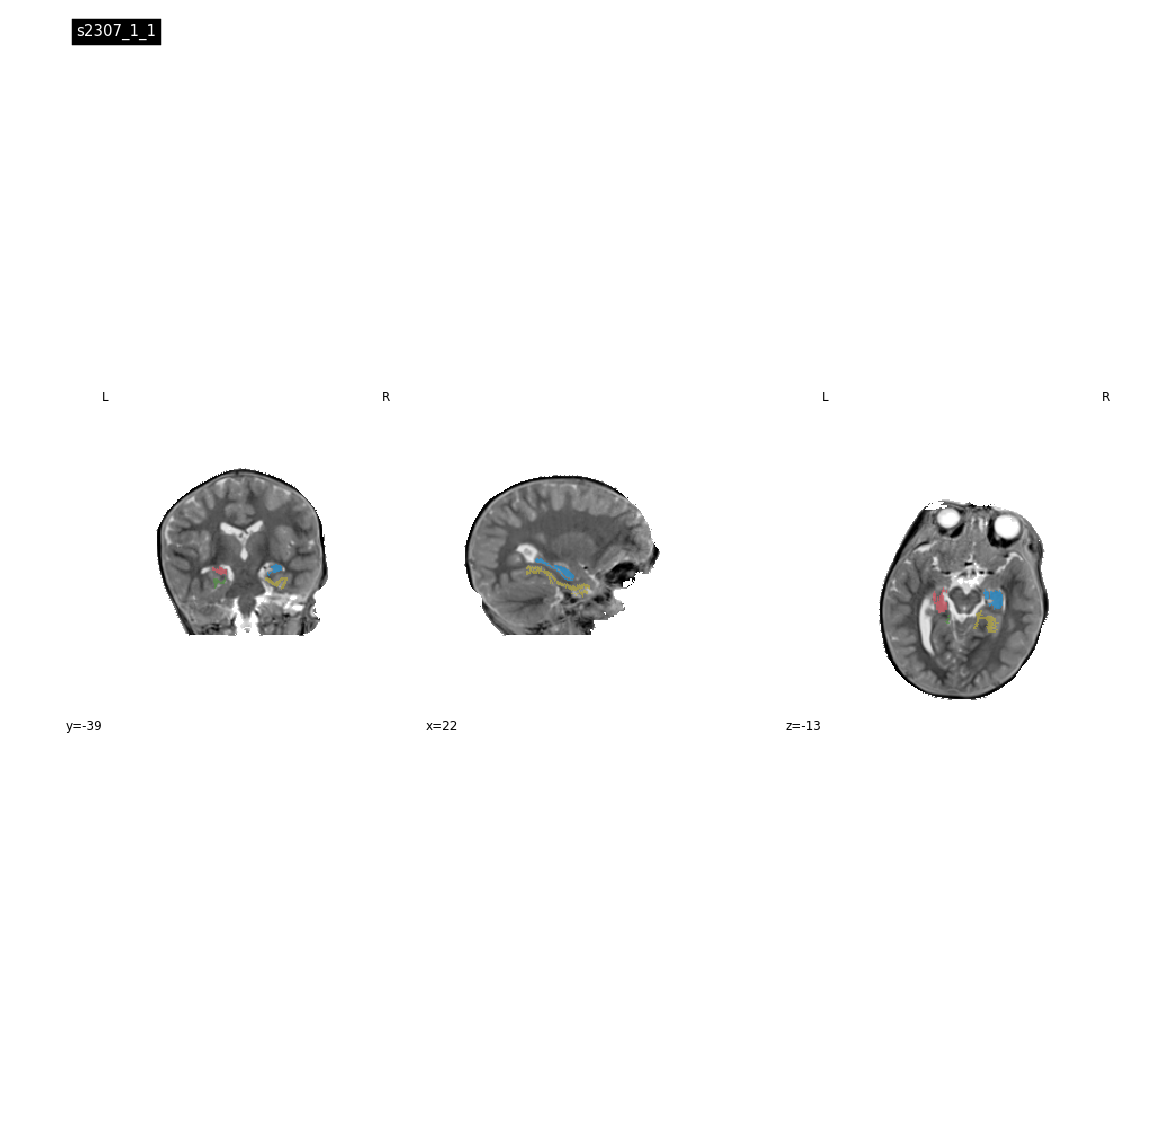

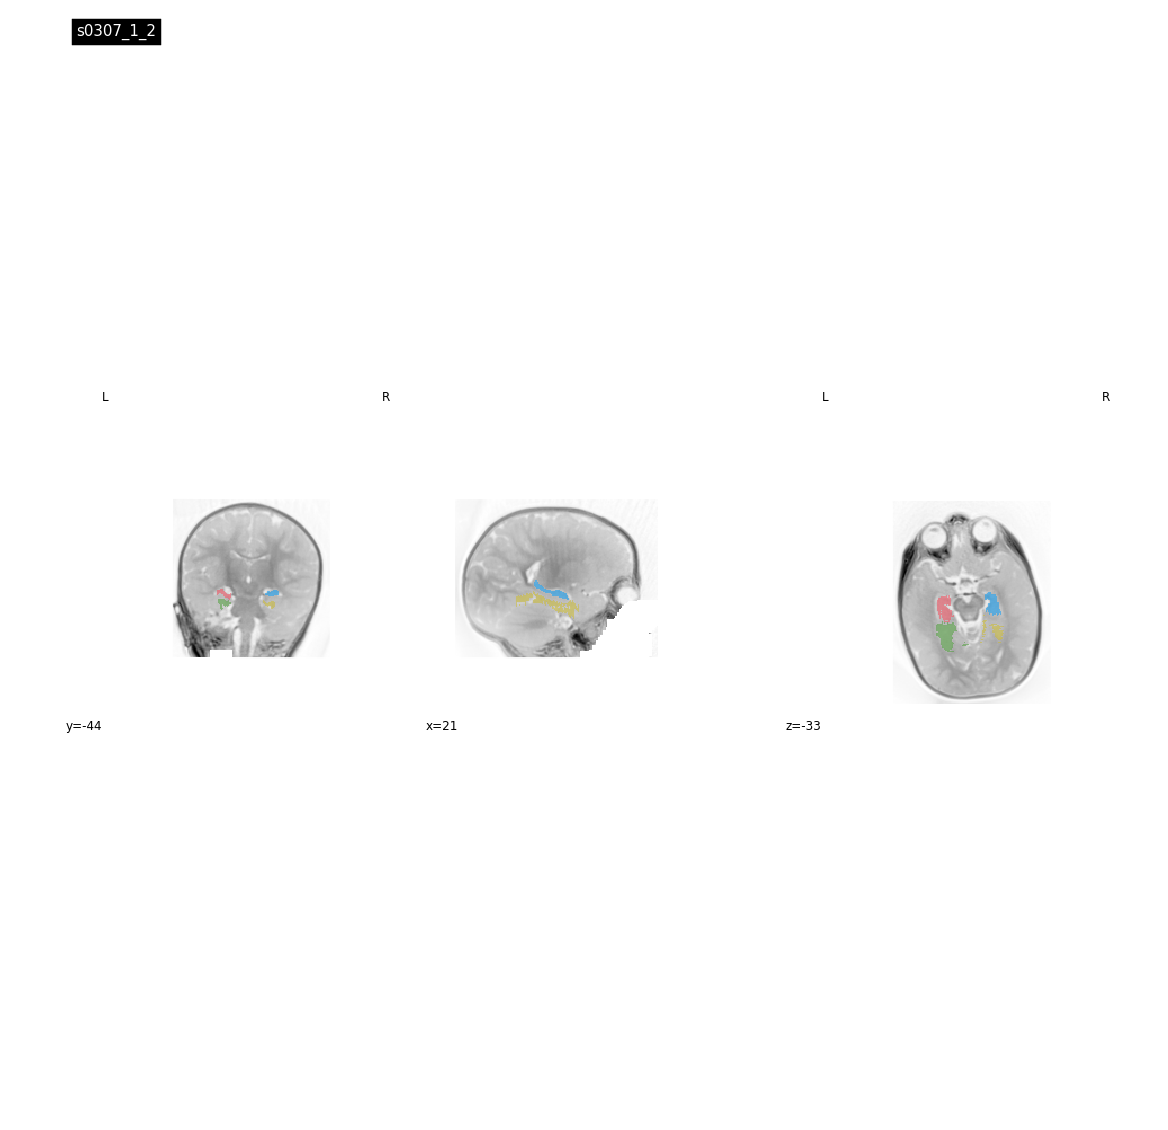

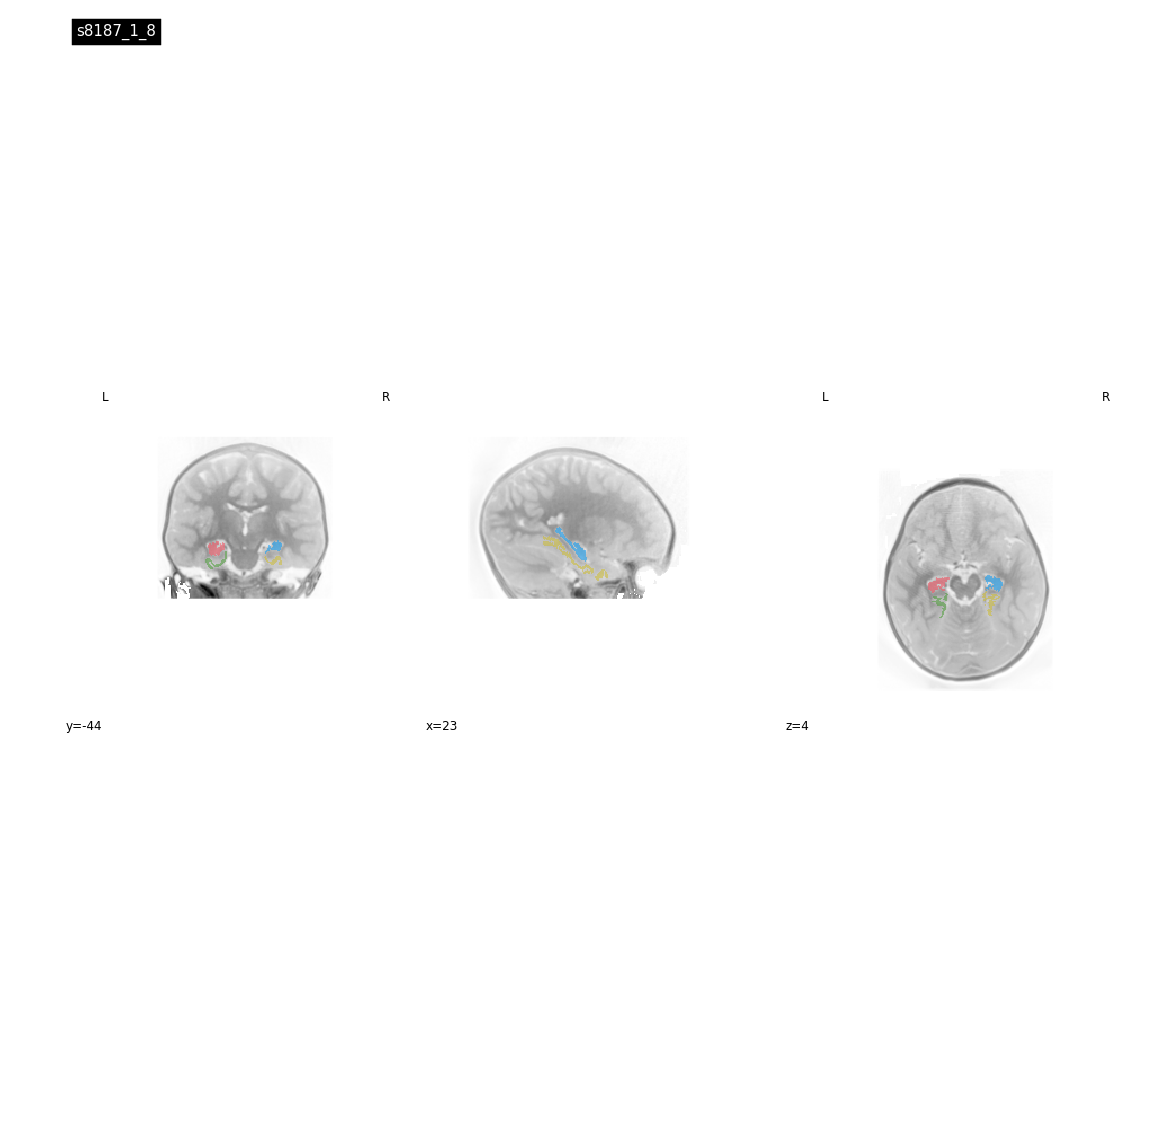

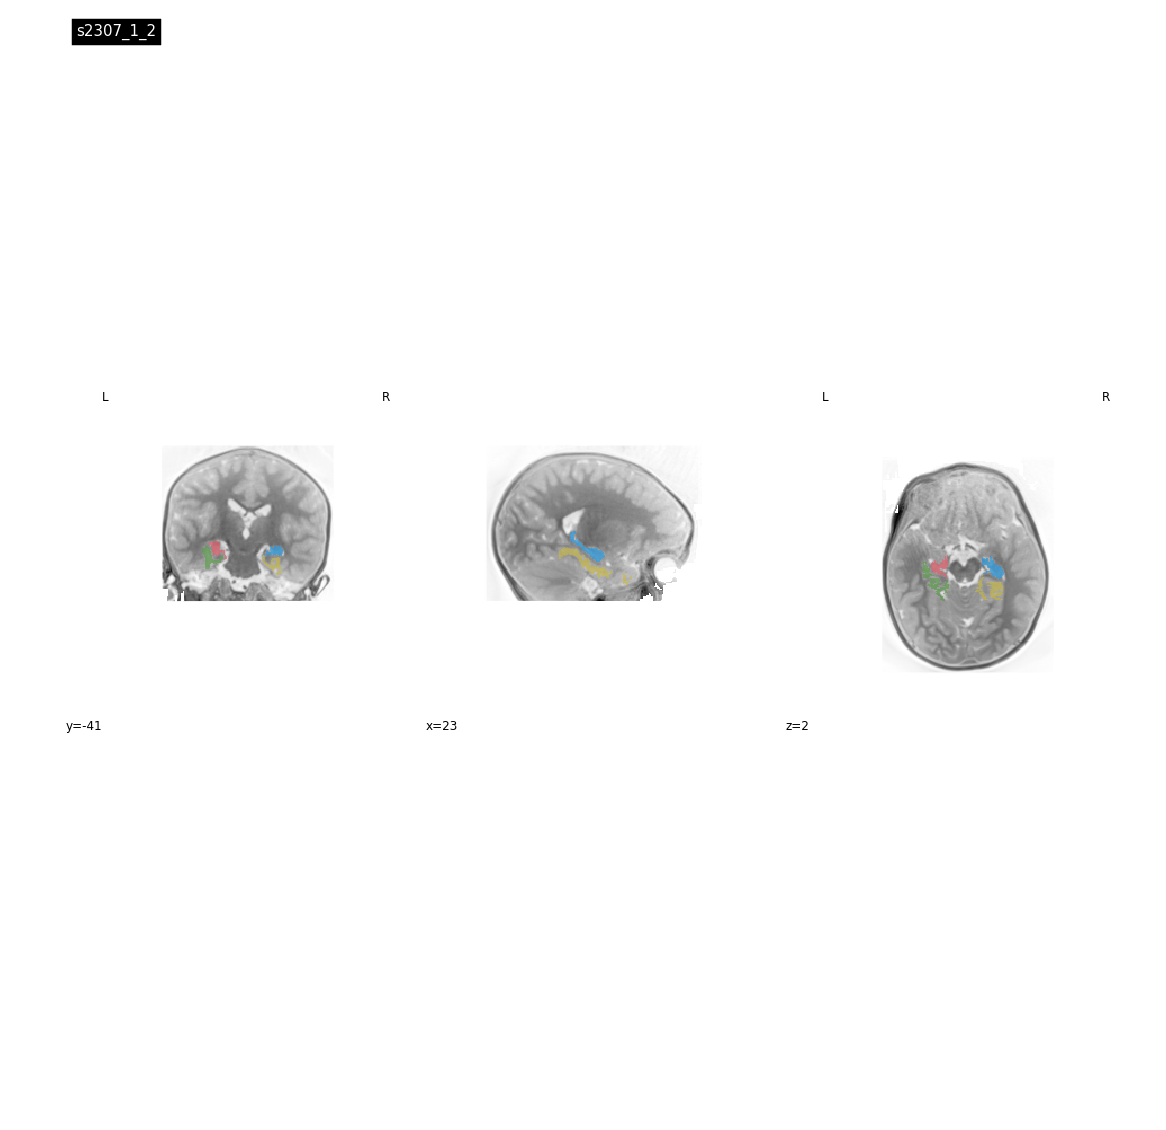

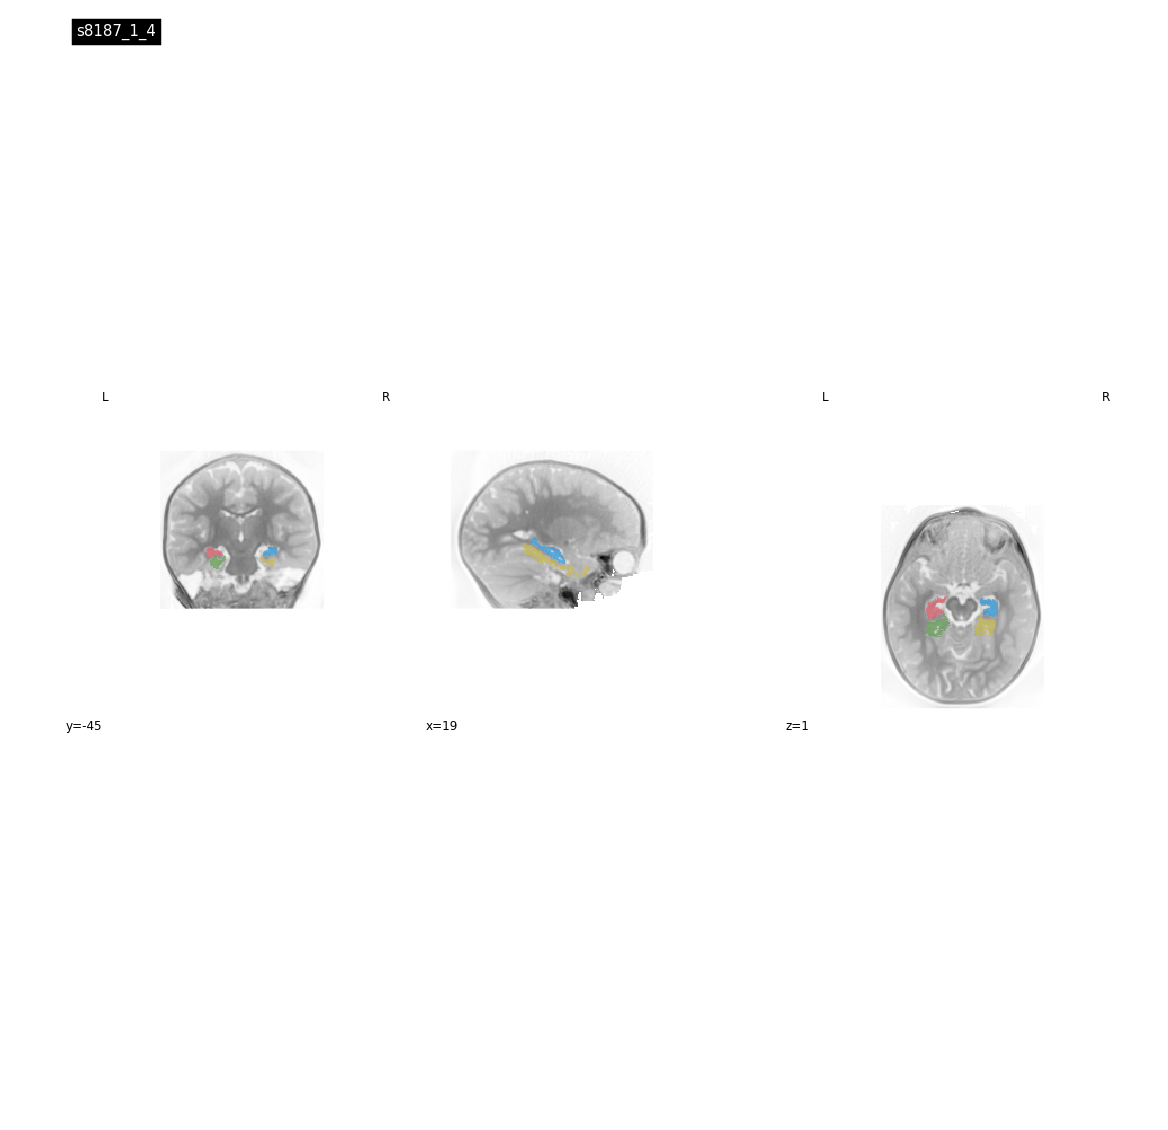

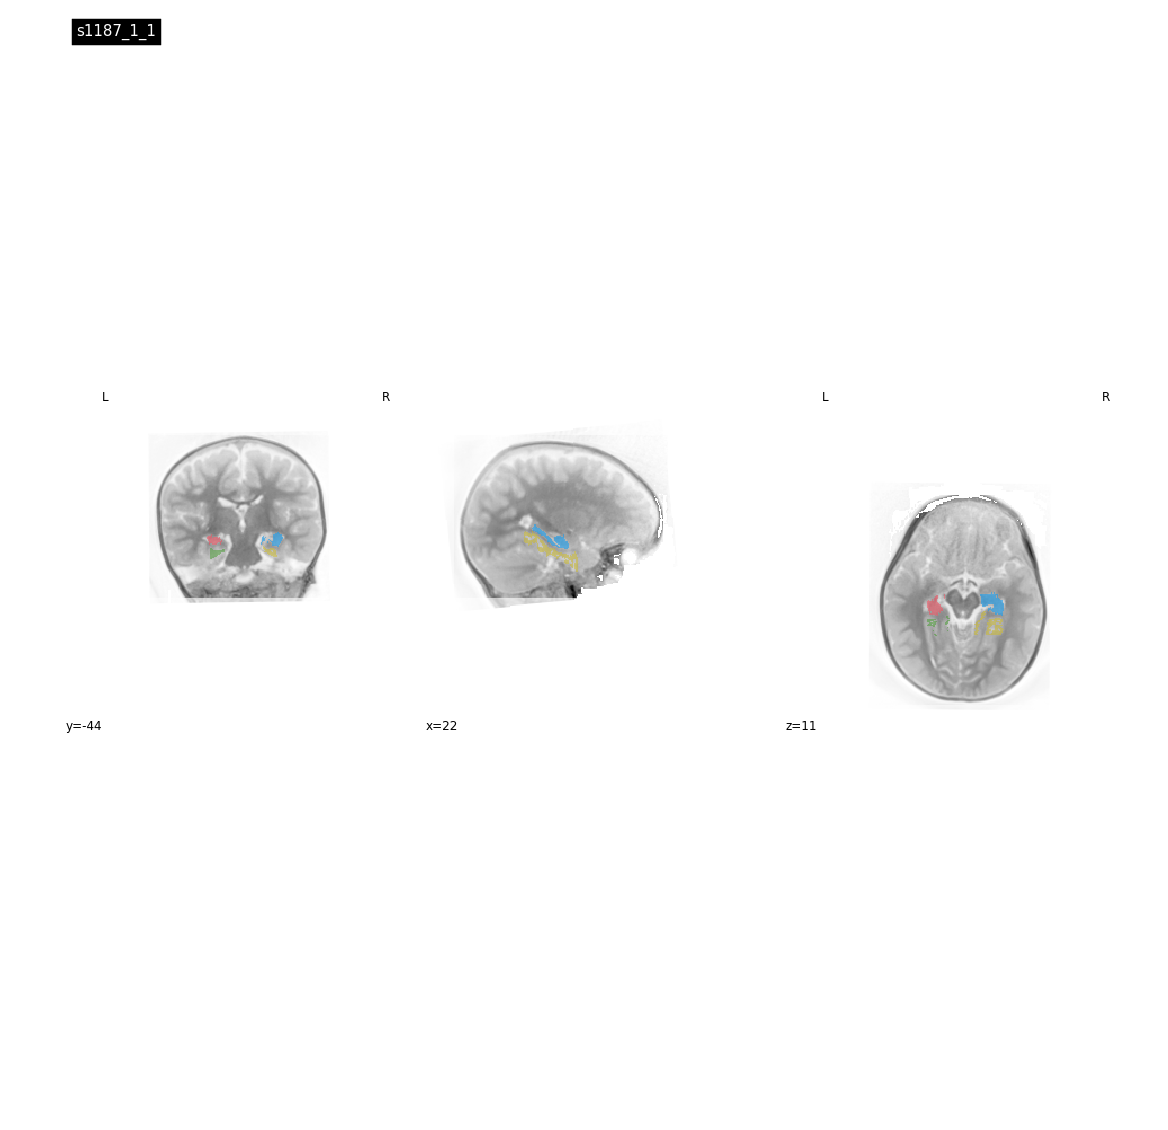

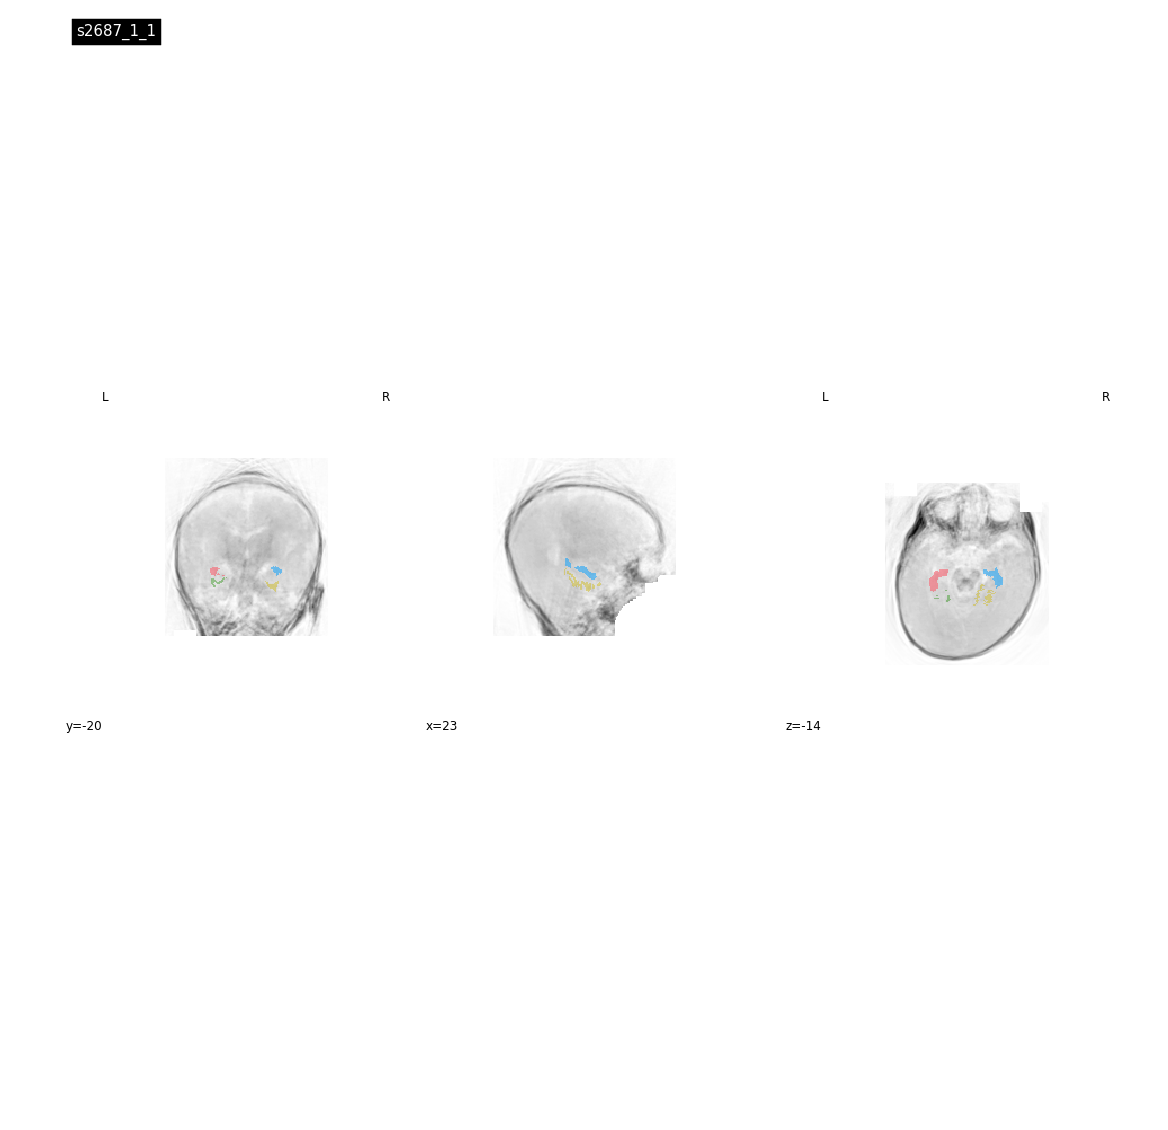

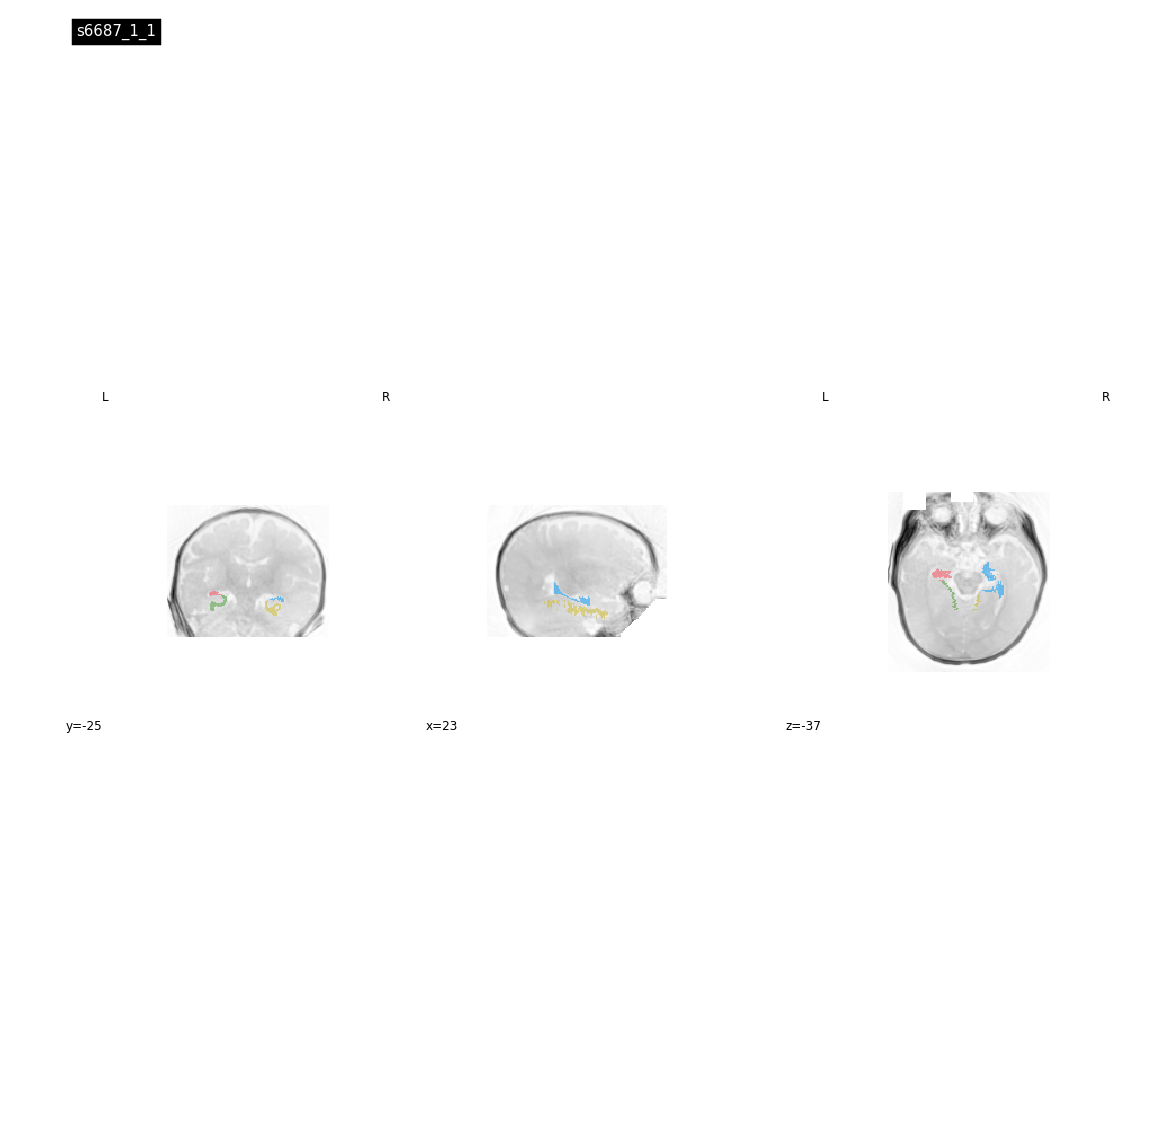

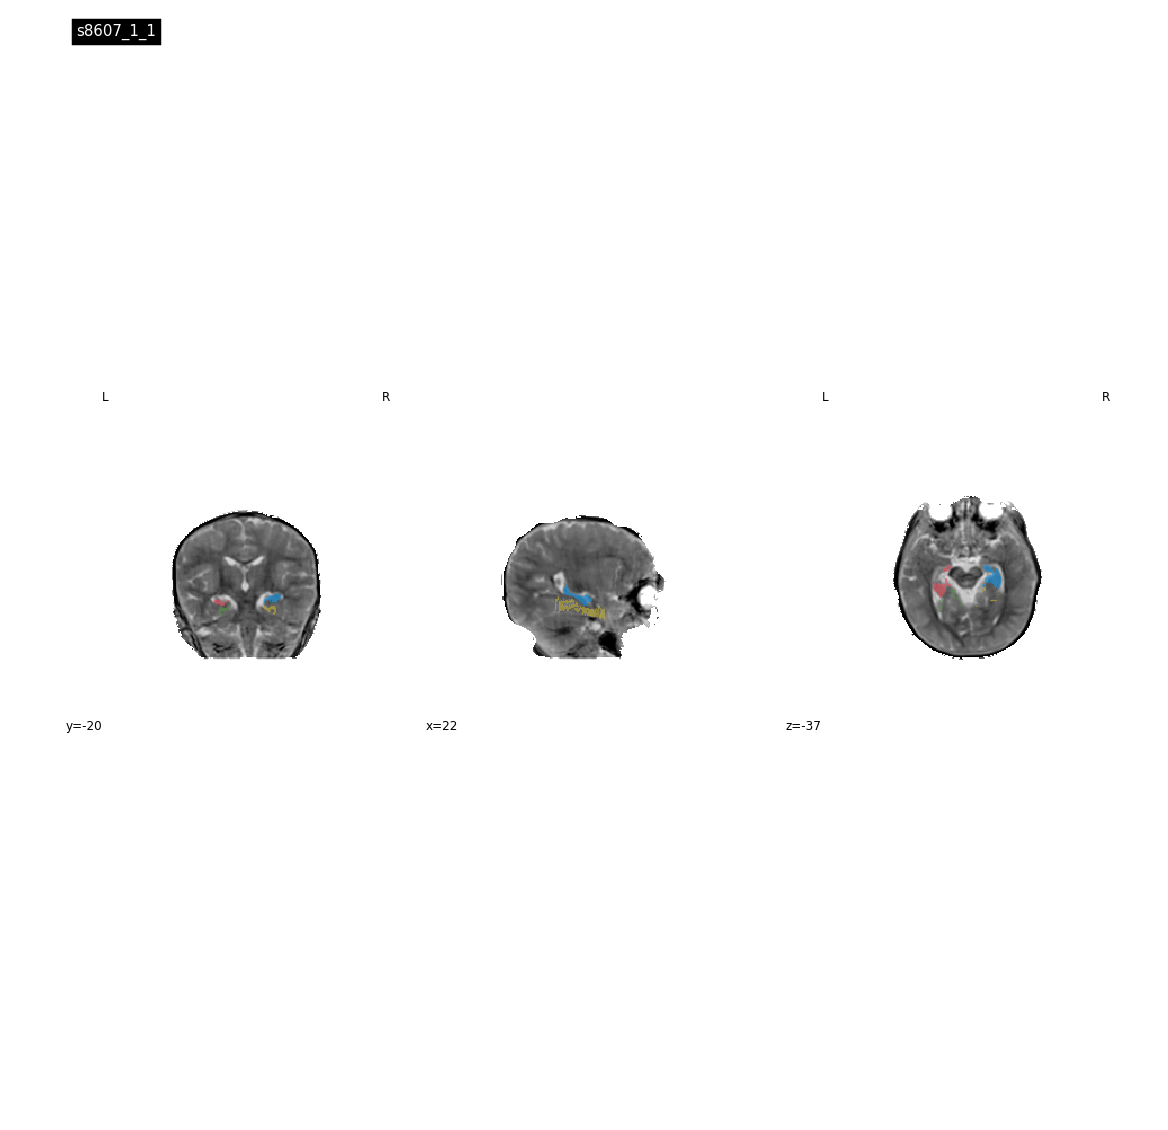

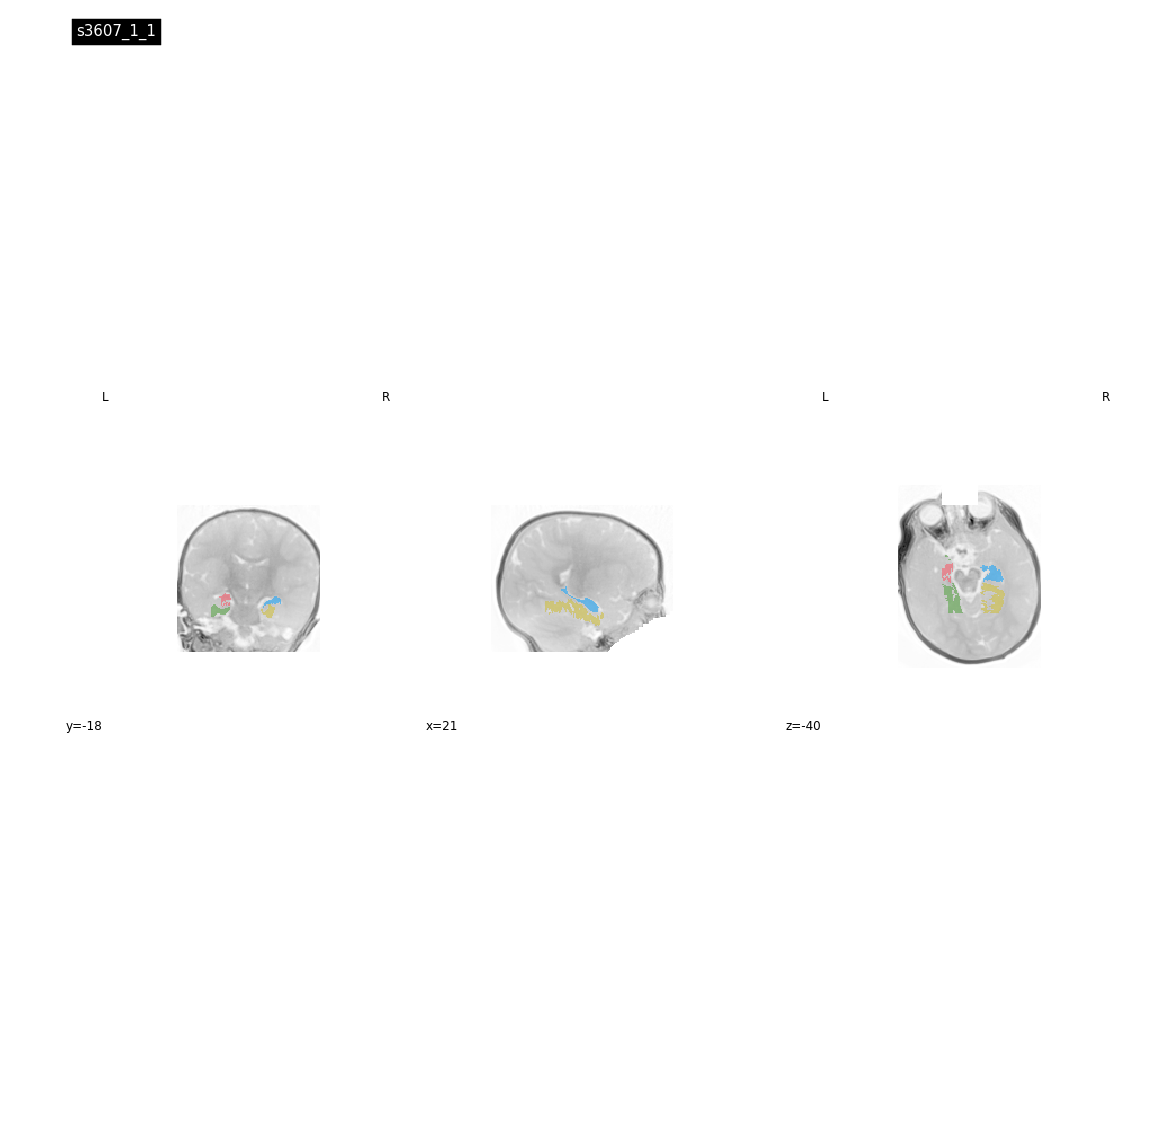

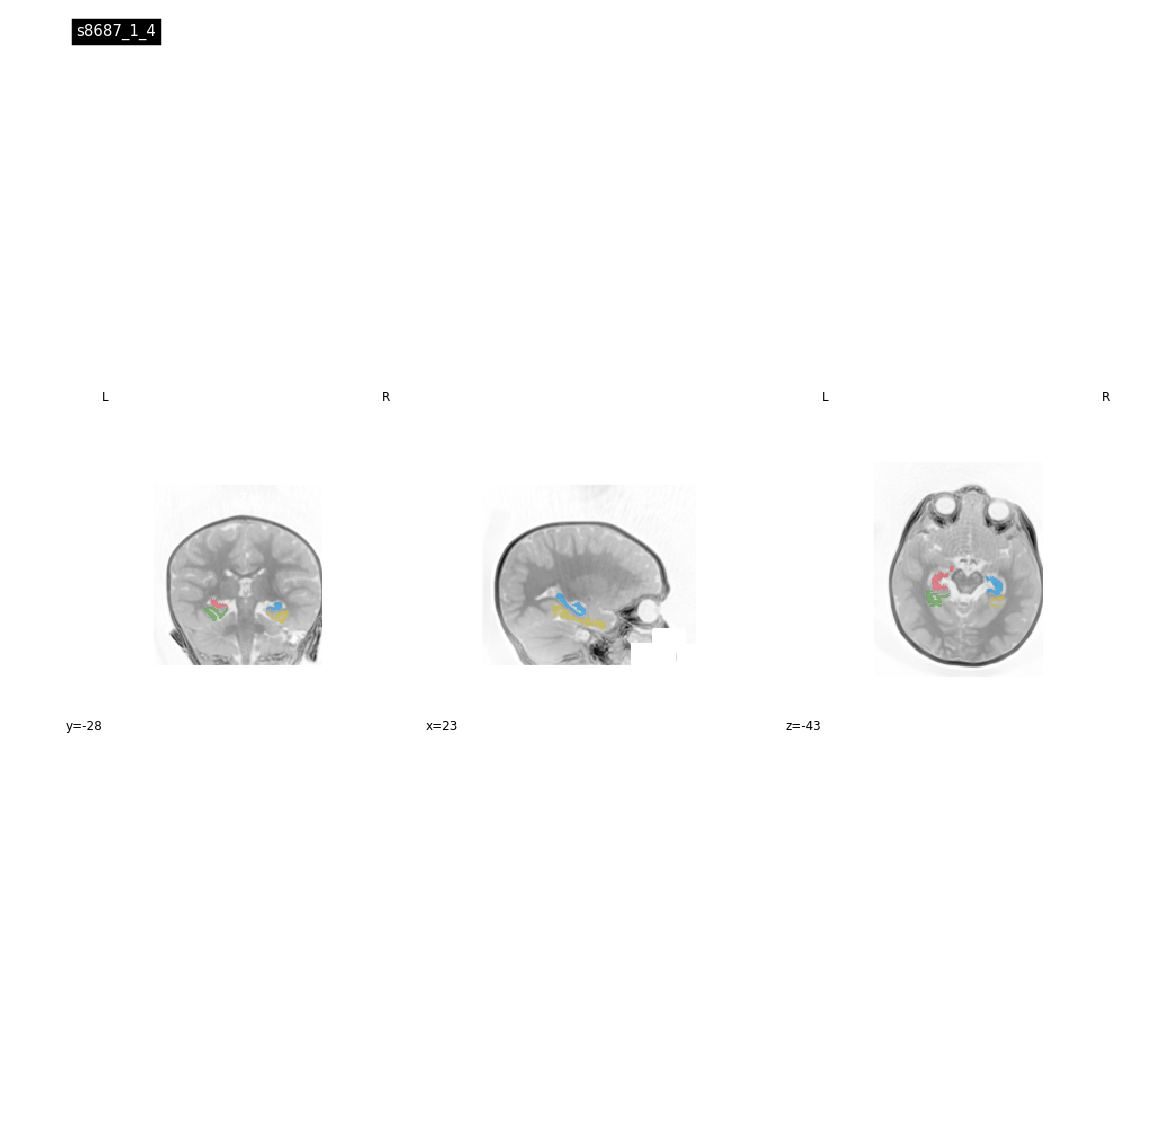

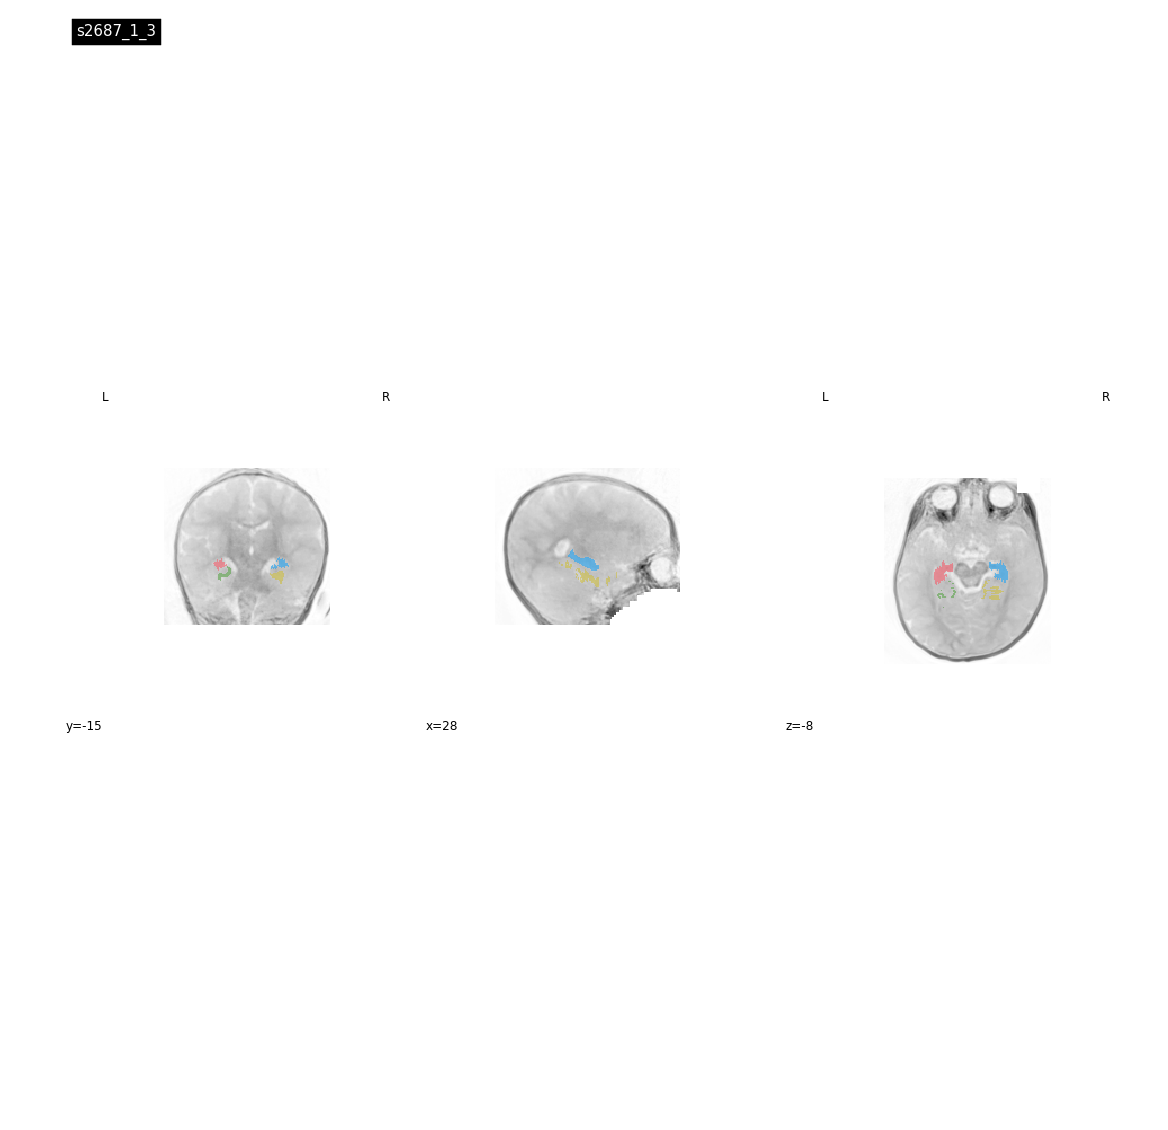

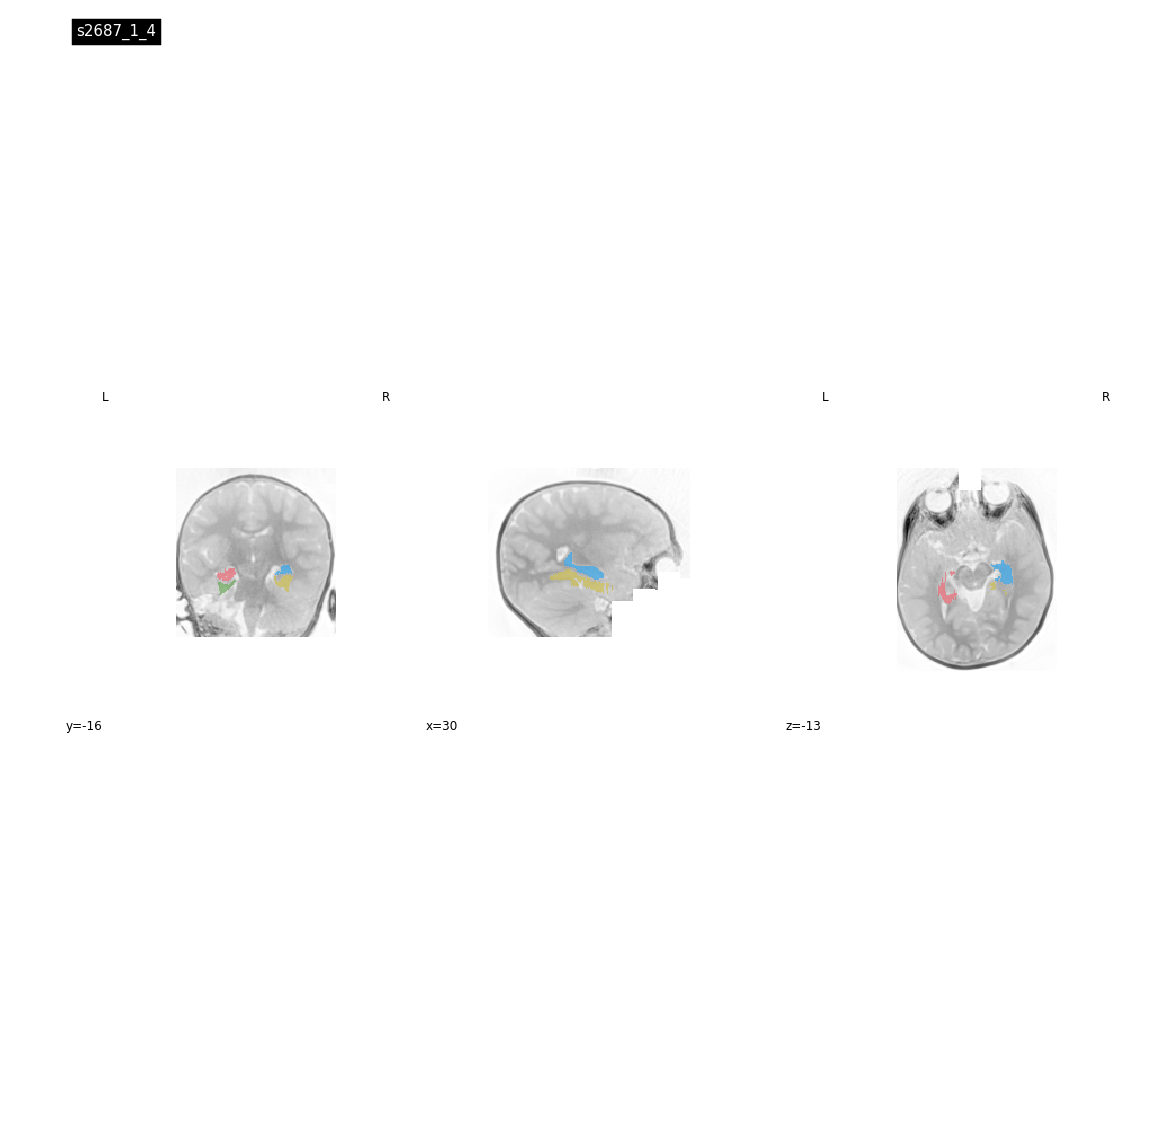

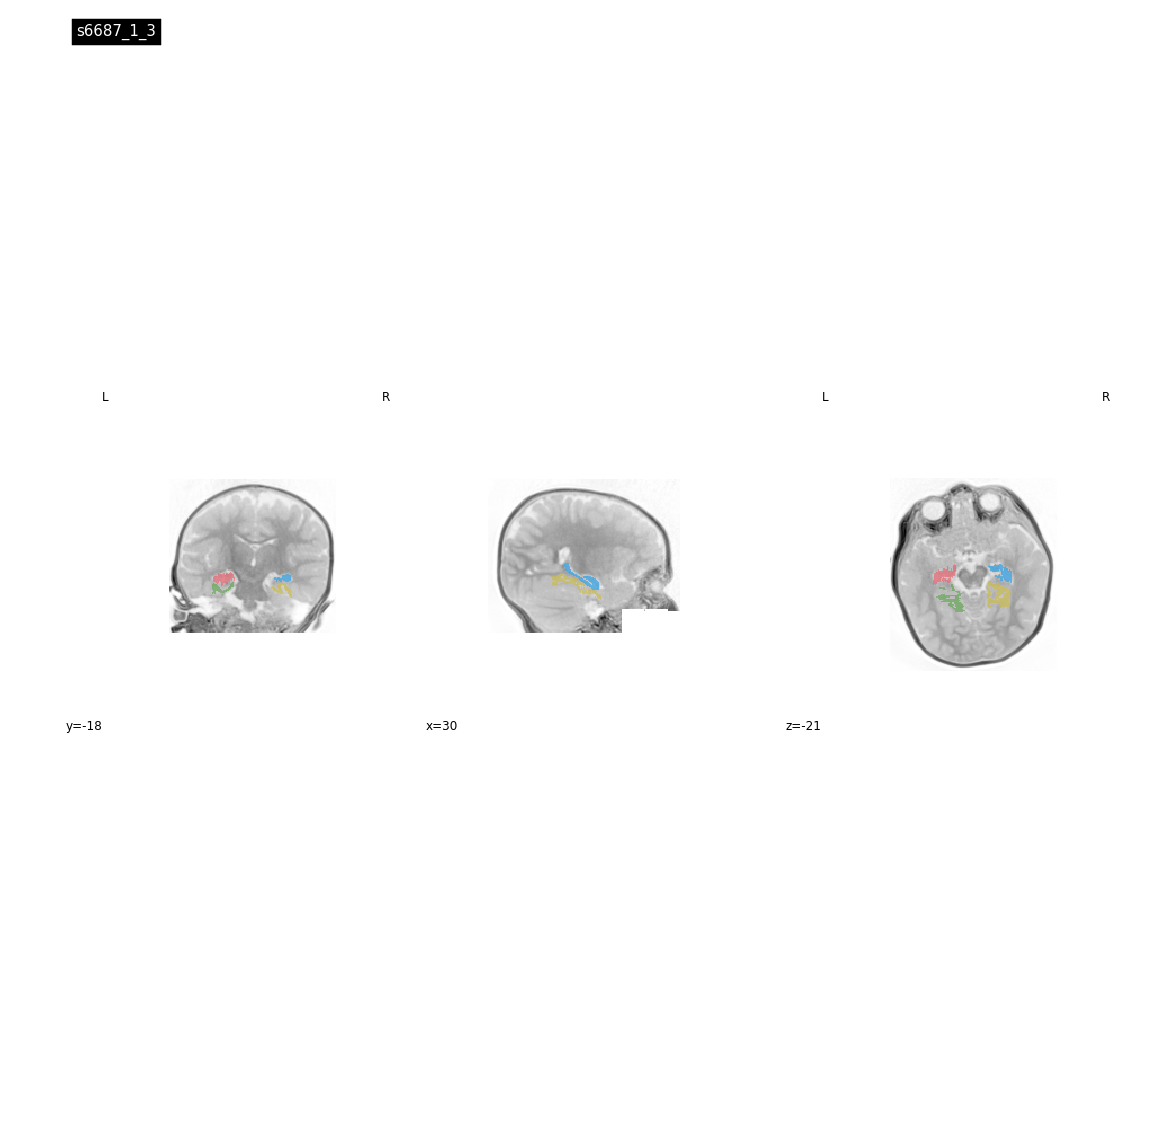

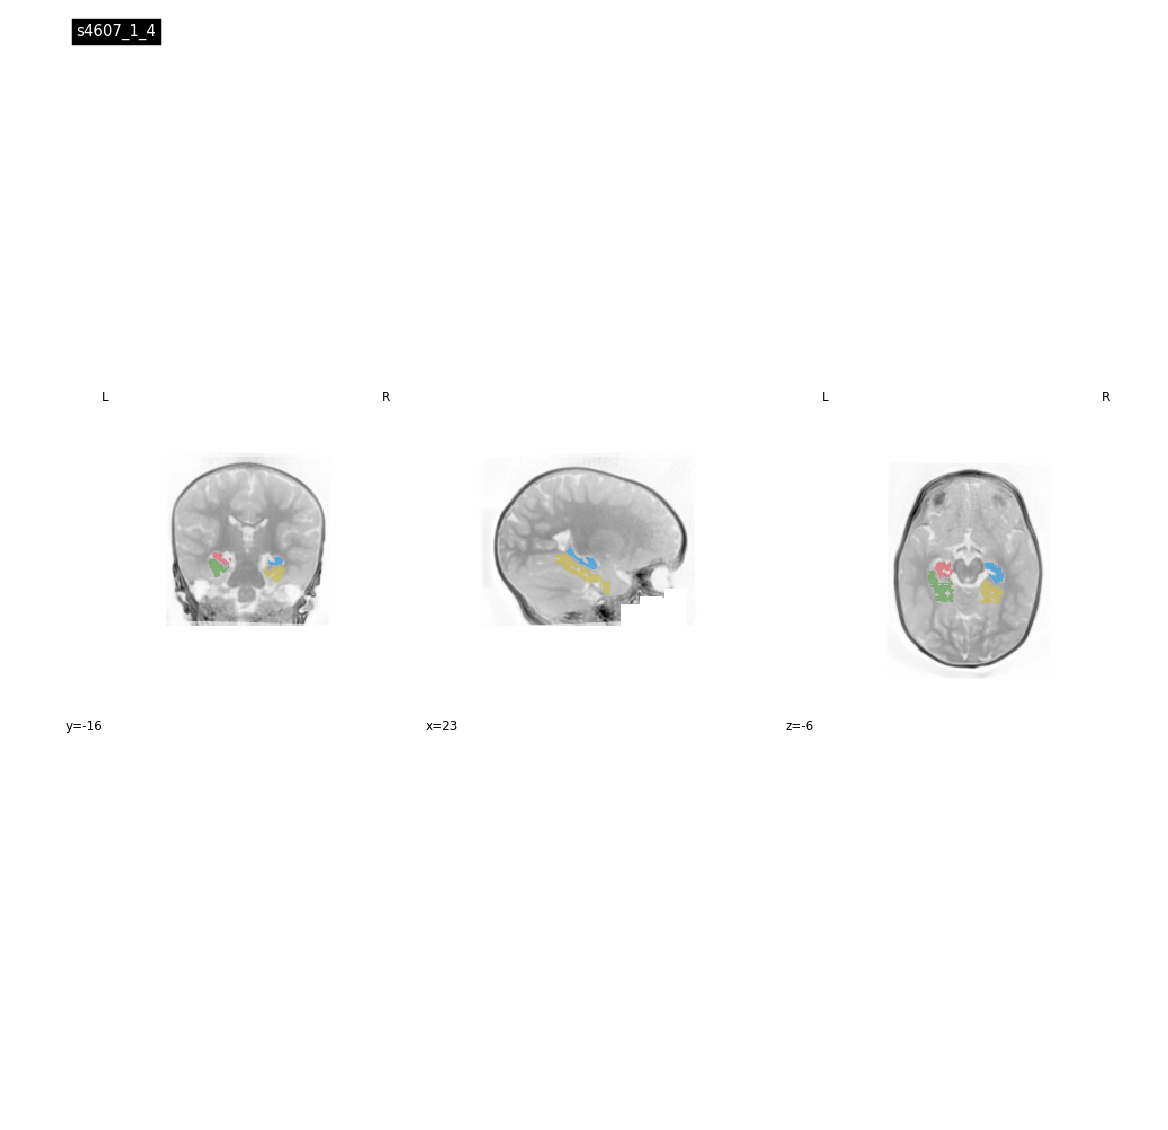

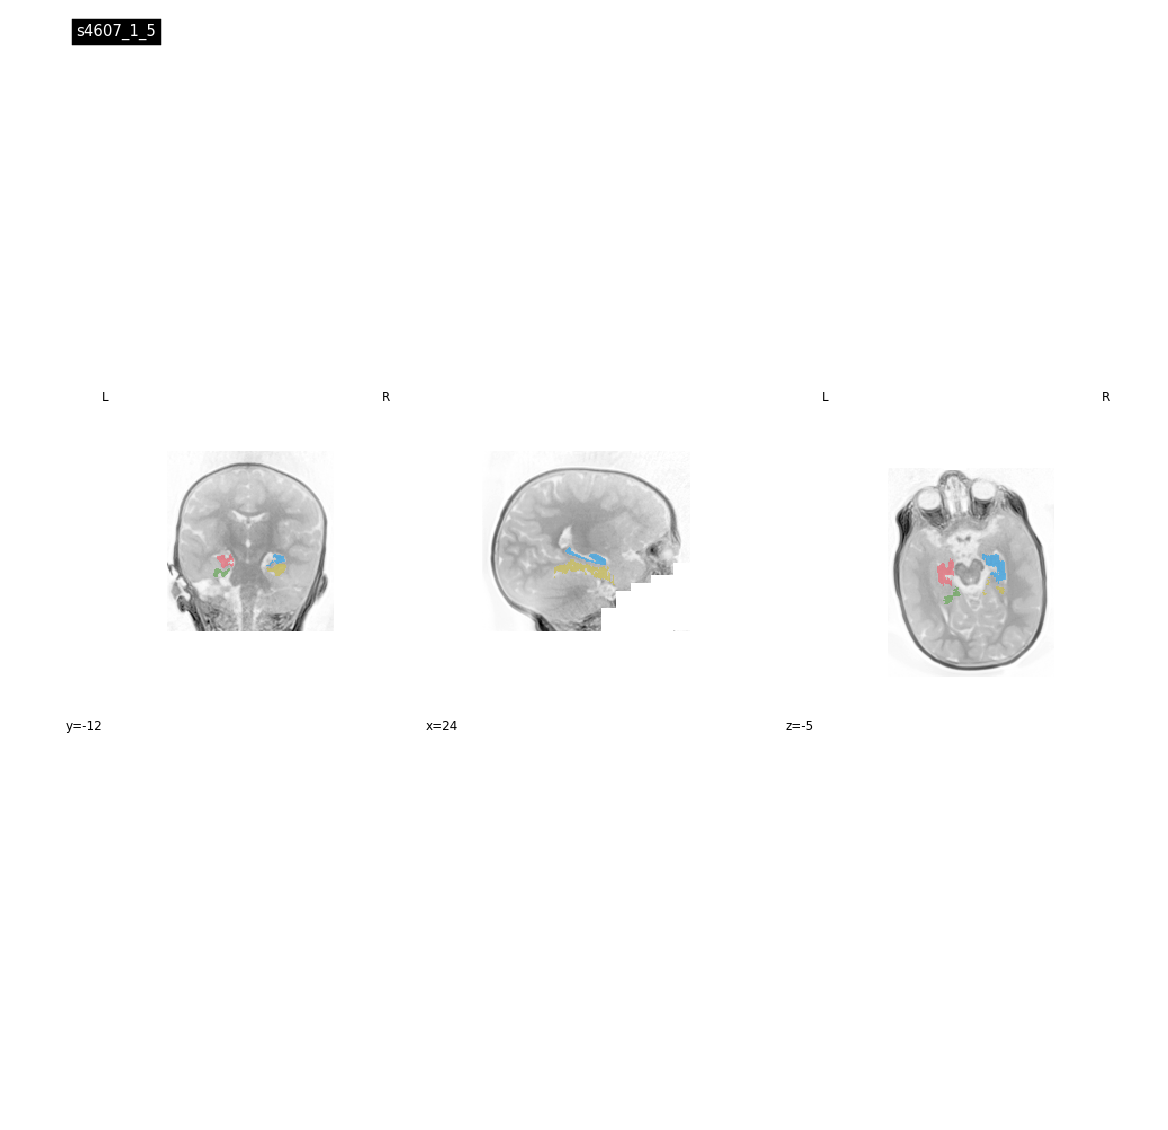

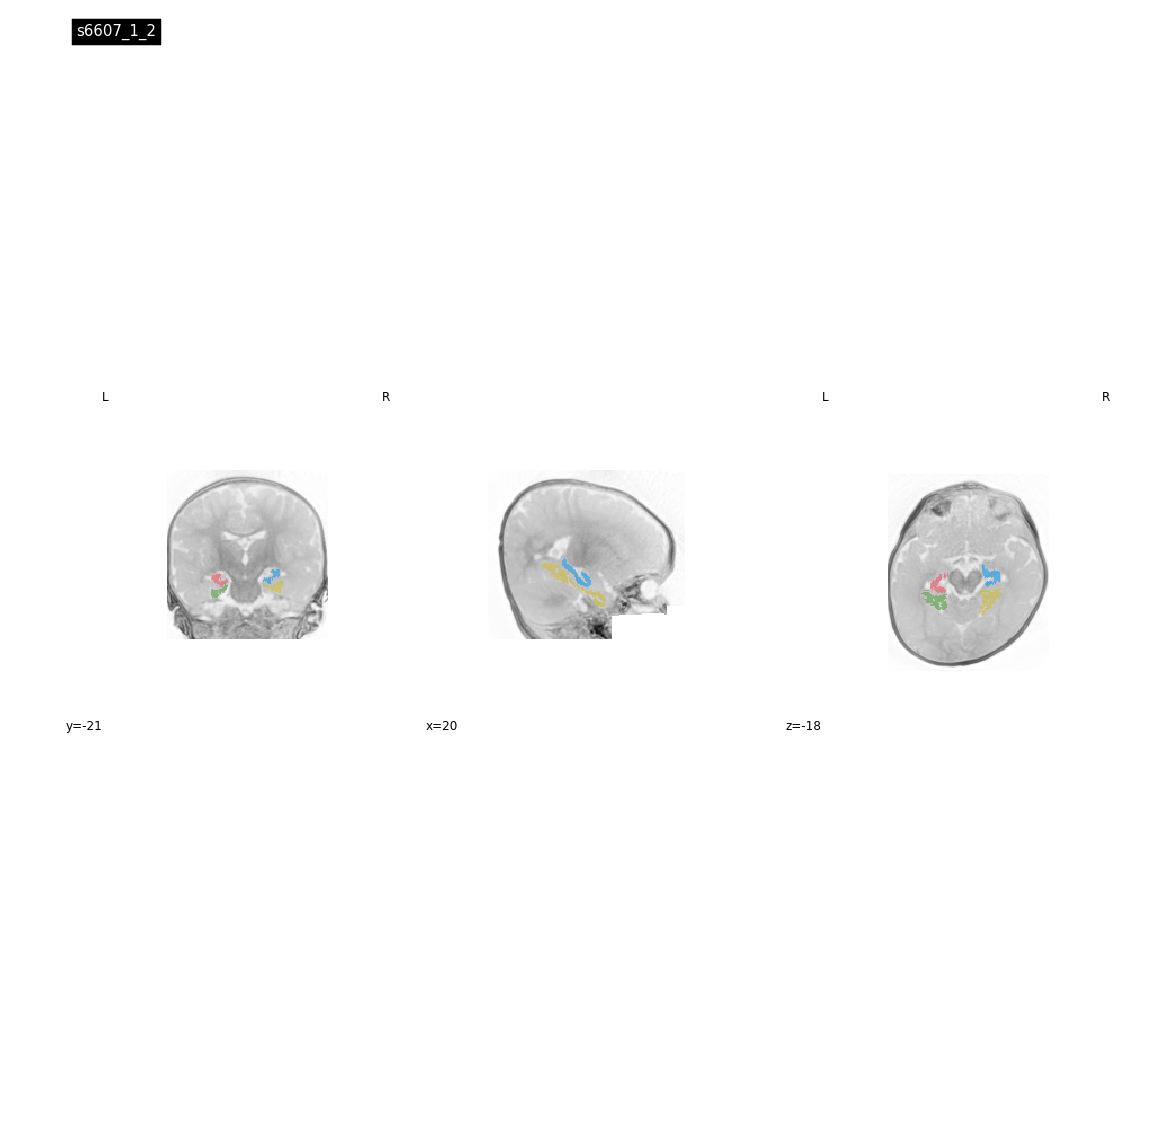

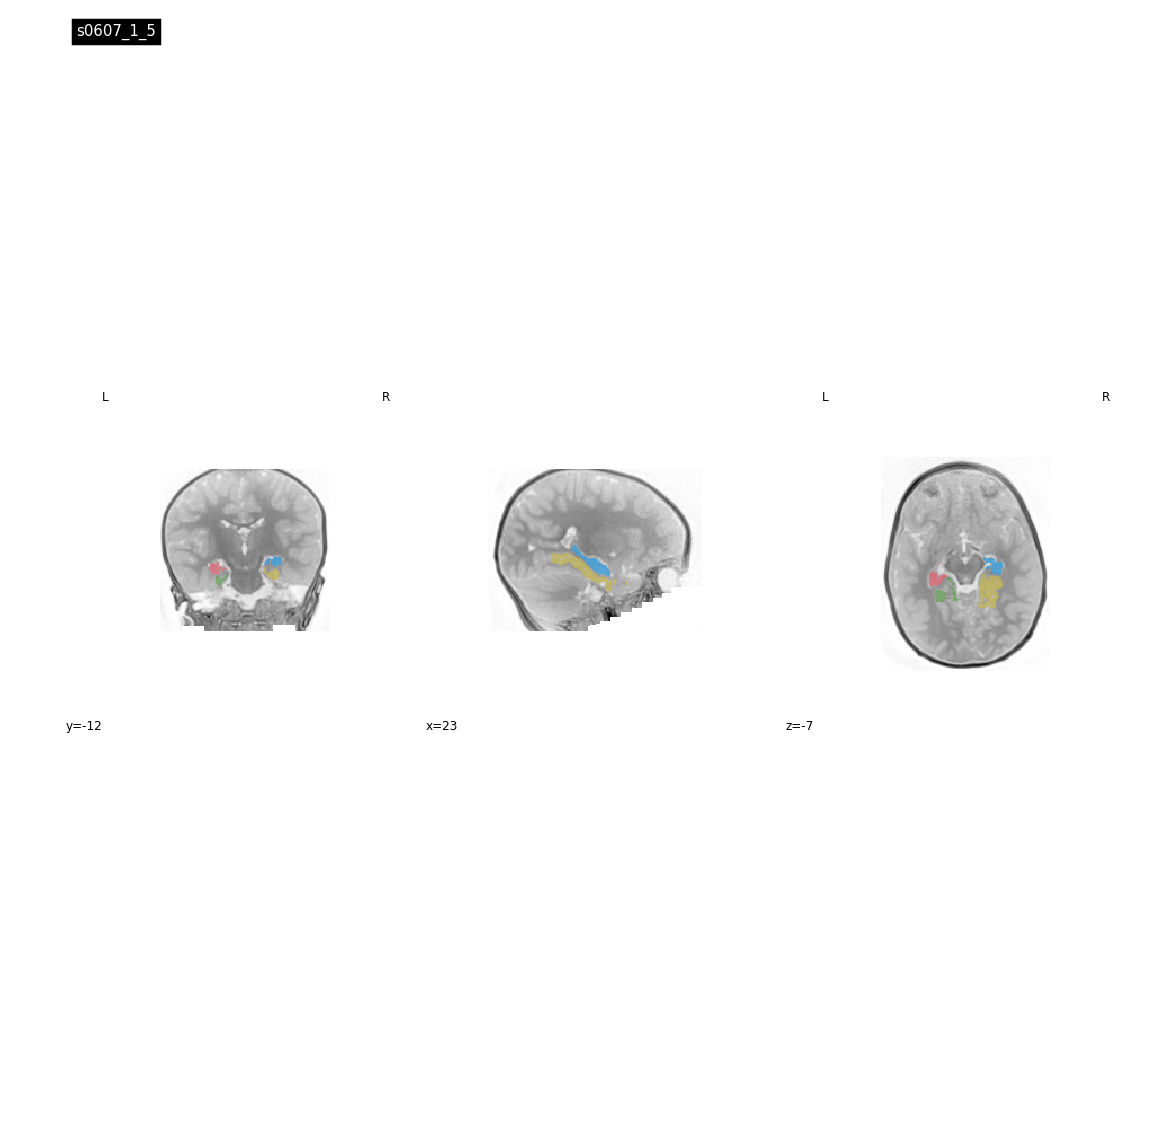

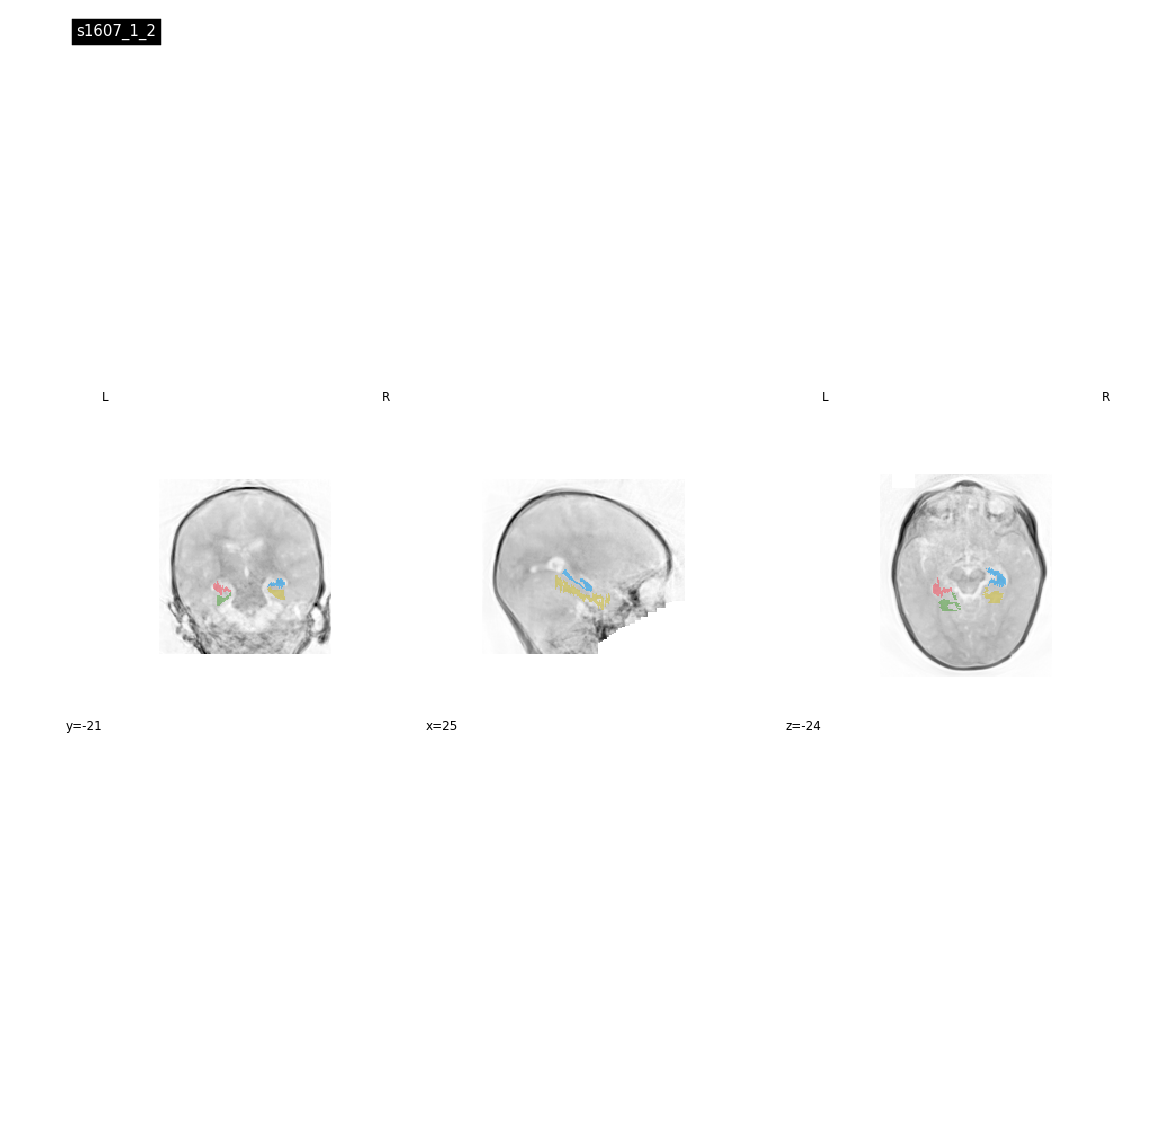

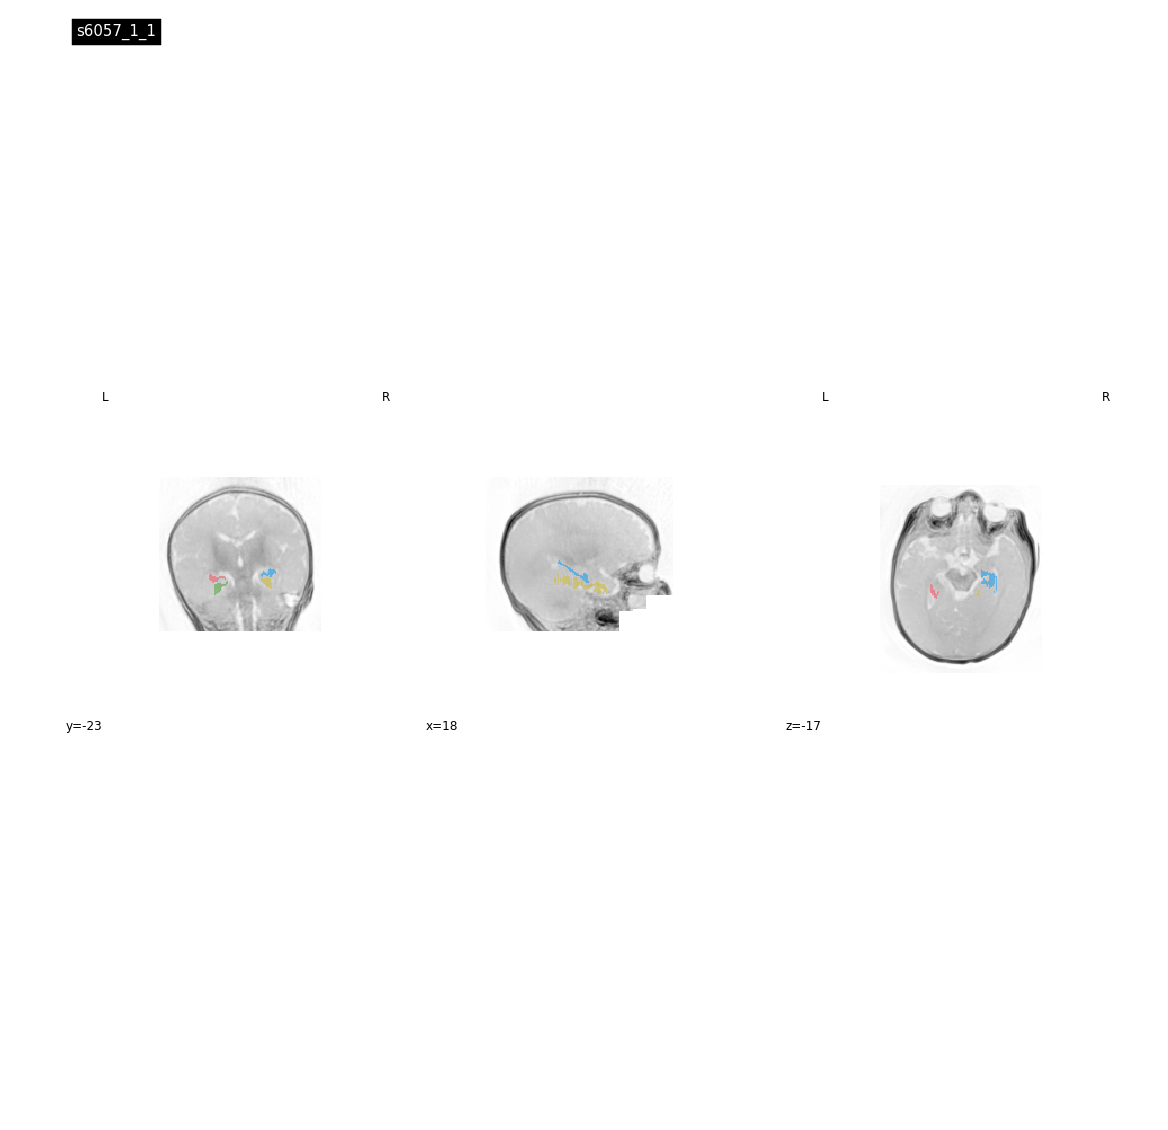

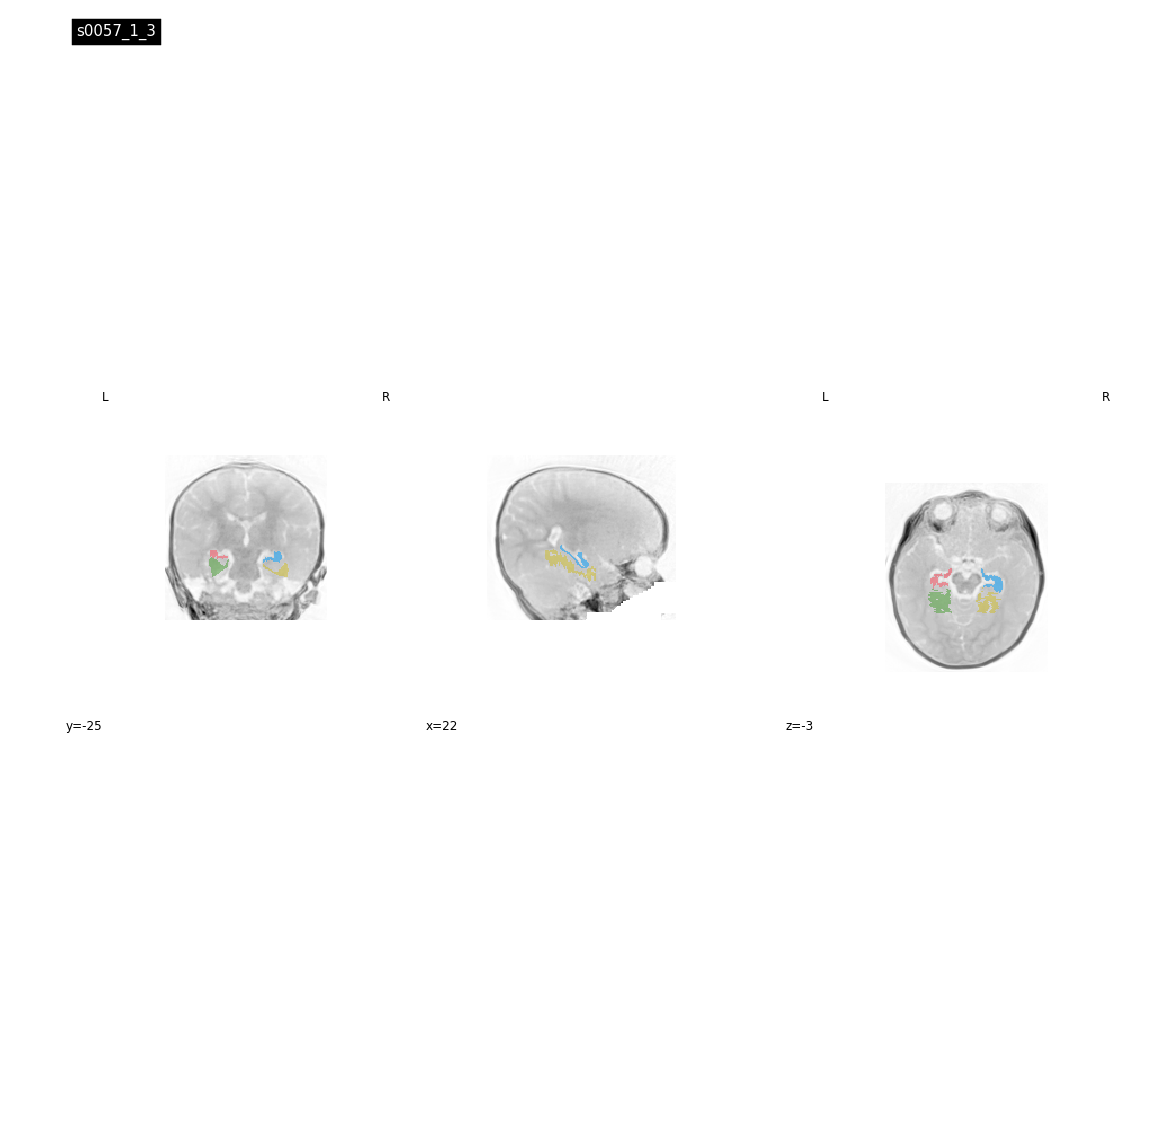

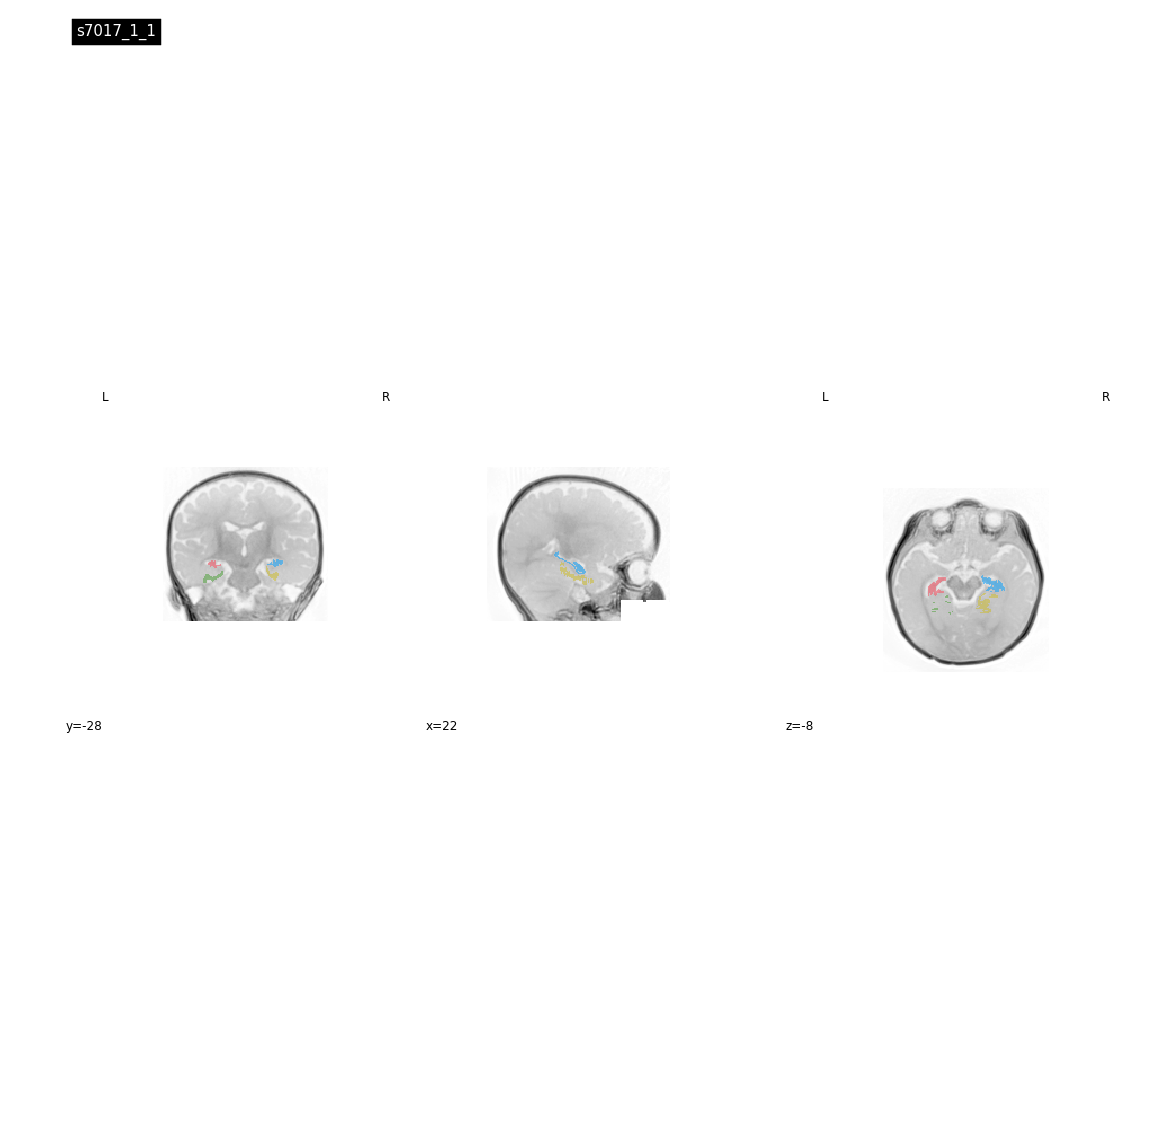

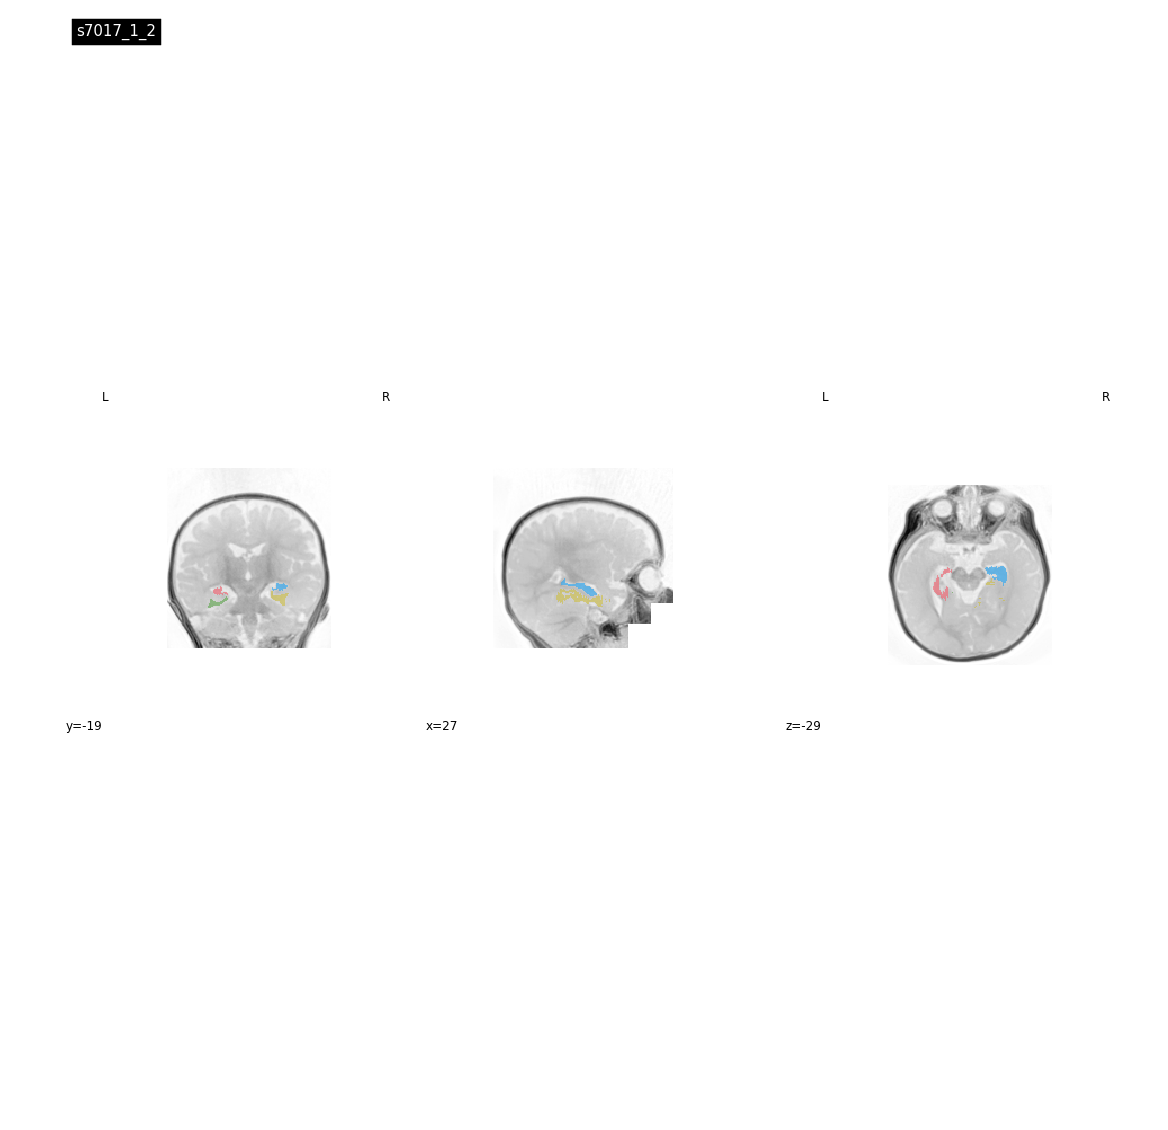

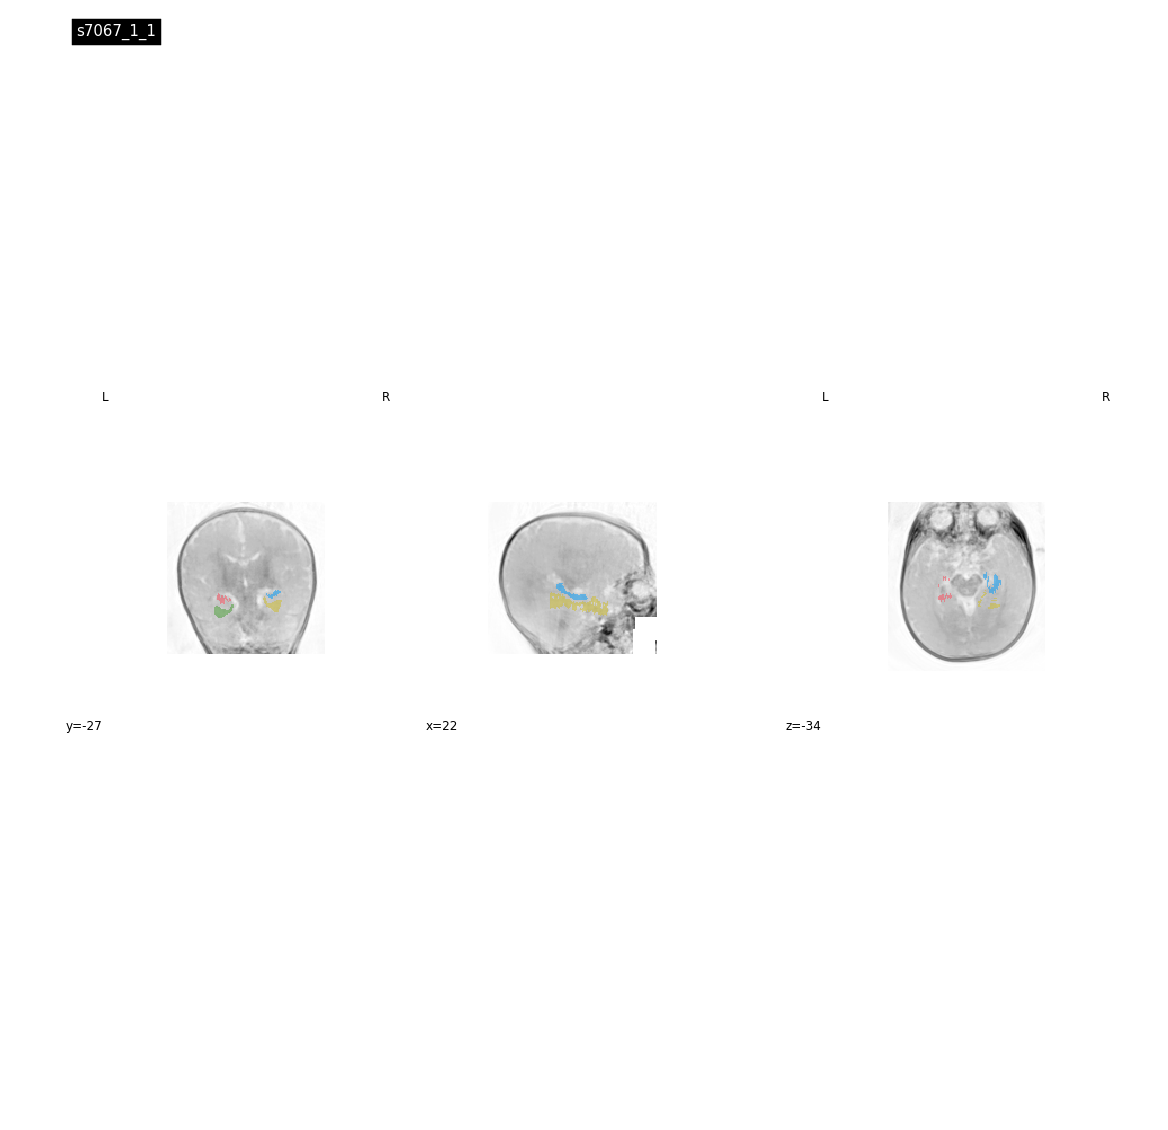

In [14]:
# Do you want to plot the head and tail of the hippocampus separately
plot_head = False

# Plot the data    
for ppt in df['ID']:
    
    plot_manual_ROI(ppt, plot_head)
    

## Get volume information about the segmentations

In [ ]:
anat_df = pd.DataFrame(columns=['Ppt', 'Age', 'Volume', 'Length', 'Centroid', 'Whole_brain'])

split_head = False
volumes = []
lengths = []
centroids = []
whole_brains = []
for ppt in df['ID']:
    
    # Where are the masks
    mask_dir = data_dir + 'segmentations/'
    
    if split_head == True:
        mask_names = glob.glob('%s/%s-%s_head.nii.gz' % (mask_dir, ppt, Coder))        
    else:
        mask_names = glob.glob('%s/%s-%s.nii.gz' % (mask_dir, ppt, Coder))
        
    if len(mask_names) == 0:
        print('No mask for', ppt)
        
    for mask_name in mask_names:

        # Load the mask
        mask_nii = nib.load(mask_name)

        # Get the volume of data
        vol = mask_nii.get_data()

        # Loop through the labels
        volume = []
        length = []
        centroid = []

        if split_head == True:
            labels = [3, 4, 5, 6, 7, 8]
        else:
            labels = [3, 4, 5, 6]

        for label in labels:

            # Get the segmented data
            segment = vol == label

            # What is the volume of this segment
            volume += [np.sum(segment)]

            # What is the length
            length += [np.max(np.where(segment == 1)[1])-np.min(np.where(segment == 1)[1])]

            # What is the centroid
            centroid += [np.round(scipy.ndimage.measurements.center_of_mass(segment)).astype('int')]
        
        # Get the whole brain model being considered
        vol = nib.load(data_dir + 'anatomical_masks/%s_mask.nii.gz' % ppt).get_data()
        whole_brain = (vol > 0).sum() # Sum the number of voxels that are non zero
        # Note critically the voxel size for this mask is 1mm (as opposed to 0.9375mm in the PETRA, so we don't need to rescale)
        
        # Append the data    
        volumes += [volume]
        lengths += [length]
        centroids += [centroid]
        whole_brains += [whole_brain]
        
anat_df['Ppt'] = np.asarray(df['ID'])
anat_df['Age'] = np.asarray(df['Age'])[ppts_both_halves]
anat_df['Volume'] = volumes
anat_df['Length'] = lengths
anat_df['Centroid'] = centroids
anat_df['Whole_brain'] = whole_brains

anat_df

In [ ]:
# Set the seed so the analyses have a consistent p value
np.random.seed(1)
plot_hpc_only = False
plot_MTL_HPC = 0 # Do you only want to plot MTL (1) or HPC (2)

if split_head == True:
    region_colors = [l_MTL, r_MTL, l_HPC, r_HPC, l_HPC_ant, r_HPC_ant]
    segmentation_order_temp = {'l_MTL': 0, 'r_MTL': 1, 'l_HPC_posterior': 2, 'r_HPC_posterior': 3, 'l_HPC_anterior': 4, 'r_HPC_anterior': 5}
else:
    region_colors = [l_MTL, r_MTL, l_HPC, r_HPC]
    segmentation_order_temp = {'l_MTL': 0, 'r_MTL': 1, 'l_HPC': 2, 'r_HPC': 3, 'MTL': [0, 1], 'HPC': [2, 3]}

# Plot either MTL or HPC    
if plot_MTL_HPC == 1:
    region_colors = [l_MTL, r_MTL]
    segmentation_order_temp = {'l_MTL': 0, 'r_MTL': 1}
    MTL_HPC_only = '_MTL'
elif plot_MTL_HPC == 2:
    region_colors = [l_HPC, r_HPC]
    segmentation_order_temp = {'l_HPC': 2, 'r_HPC': 3}
    MTL_HPC_only = '_HPC'
else: 
    MTL_HPC_only = ''
    
# Plot the data for this anatomical information
for data_type in ['Volume']: #, 'Length']:
    plt.figure()
    for seg_counter, key in enumerate(segmentation_order_temp):
        
        # What ROI are you considering
        roi = segmentation_order_temp[key]
        
        # Get the volume of this ROI
        volume = []
        for volumes in anat_df[data_type]:
            
            if isinstance(roi, list):
                volume += [volumes[roi[0]] + volumes[roi[1]]]
            else:
                volume += [volumes[roi]]
        
        # Only necessary because the voxel sizes of PETRA are 0.9375
        if data_type is 'Volume':
            volume = np.asarray(volume) * (0.9375 ** 3)
        else:
            volume = np.asarray(volume) * 0.9375
            
        # Plot the data    
        if (plot_hpc_only == False) or (seg_counter > 1):
            if isinstance(roi, list) == False:
                plt.scatter(anat_df['Age'], volume, c=np.asarray(region_colors[seg_counter][:3]).reshape(1, 3))
                plt.legend(segmentation_order_temp.keys())
                plt.ylabel(data_type)
                plt.xlabel('Age')
        
        # Get the correlation value
        if is_pearson == 1:
            r_val, _ = stats.pearsonr(anat_df['Age'], volume)
        else:
            r_val, _ = stats.spearmanr(anat_df['Age'], volume)
        slope_val, _, _, _, _ = stats.linregress(anat_df['Age'], volume)
        
        p_val = randomise_corr(anat_df['Age'], volume)
        
        # Get the partial correlation value
        partial_r_val, _, partial_slope_val = partial_corr(anat_df['Age'], volume, anat_df['Whole_brain'])
        partial_p_val = randomise_corr(np.asarray(anat_df['Age']), volume, cov_vals=np.asarray(anat_df['Whole_brain']))
        
        print('%s: r between %s and age: %0.3f, slope=%0.3f p=%0.3f (partial, slope=%0.3f r=%0.3f, p=%0.3f)' % (key, data_type, r_val, slope_val, p_val, partial_slope_val, partial_r_val, partial_p_val))

    plt.savefig(data_dir + 'plots/ROI_scatter_%s%s.svg' % (data_type, MTL_HPC_only))
    
# Compute the ratio of volume of the posterior and anterior and correlate with age
if split_head == True:
    
    l_ratio = []
    r_ratio = []
    for volume in anat_df['Volume']:
        l_ratio += [volume[4] / (volume[2] + volume[4])]
        r_ratio += [volume[5] / (volume[3] + volume[5])]
    
    plt.figure()
    plt.scatter(anat_df['Age'], l_ratio, c=l_HPC_ant)
    plt.scatter(anat_df['Age'], r_ratio, c=r_HPC_ant)
    plt.xlabel('Age')
    

In [ ]:
MTL = []
HPC = []
for volume in anat_df['Volume']:

    MTL += [(volume[segmentation_order_temp['l_MTL']] + volume[segmentation_order_temp['r_MTL']])  * (0.9375 ** 3)]
    HPC += [(volume[segmentation_order_temp['l_HPC']] + volume[segmentation_order_temp['r_HPC']])  * (0.9375 ** 3)]

print('Volume of MTL %0.3f (SD=%0.3f)' % (np.mean(MTL), np.std(MTL)))    
print('Volume of hippocampus %0.3f (SD=%0.3f)' % (np.mean(HPC), np.std(HPC)))    
    

In [ ]:
# Do whole brain volume
r_val = np.corrcoef(anat_df['Age'], anat_df['Whole_brain'])[0, 1]
slope_val, _, _, _, _ = stats.linregress(anat_df['Age'], anat_df['Whole_brain'])
plt.title('Brain volume x age correlation: b=%0.3f r=%0.3f' % (slope_val, r_val))
plt.xlabel('Age')
plt.ylabel('Volume')
plt.scatter(anat_df['Age'], anat_df['Whole_brain'])

## Structured vs Random <a id='main_results'></a>

Pull out the data for each of the ROIs for each type of contrast under consideration.  

For 'StatLearning_Interaction' the contrast numbers mean:  
1 - Structured vs Random  
2 - Second half vs first half  
3 - Interaction (Structured second - first greater than Random second - first)  
4 - Structured first half  
5 - Structured second half  
6 - Random first half  
7 - Random second half  
8 - Structured vs Random first half  
9 - Structured vs Random second half  
10 - Second vs First Structured  
11 - Second vs First Random  
12 - Second Random vs all  
13 - Second Random vs First Structured  
14 - Second Structured vs all  
15 - Second Structured vs First Random  

These contrasts are used to produce the results reported in the paper. For instance, contrast 3 is used to evaluate whether there is an interaction effect. Contrast 8 and 9 are used to plot the difference between Structured and Random blocks for each half. We can then specify how to aggregate/split ROIs to show the results.

The data from each participant is stored in the `masked_data` variable. This is a list of arrays where each list element is a contrast. Because of Python's zero indexing, contrast 3 is in list element 2.

In [ ]:
# Set the seed so the analyses have a consistent p value
np.random.seed(1)

### Bilateral hippocampus and MTL

In [ ]:
feat_type='StatLearning_Interaction-seen_Z'
bilaterial_name = '_bilateral' 
posterior_anterior_name = ''

# Load the data
output_name = data_dir + 'masked_data/masked_data_%s_%s%s%s.npy' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name)     

masked_data, temp_seg_order = load_masked_data(feat_type, output_name)

print('%s_%s%s%s' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
plt.figure(figsize=(6, 16))
for label_counter, label in enumerate(temp_seg_order):
    plt.subplot(2, 2, label_counter + 1)
    print(label)
    plot_data(masked_data[7:9], temp_seg_order[label], ppts_included=ppts_both_halves)
    interaction_pval, interaction_sign_count, interaction_CI = randomise_diff(diff_data=masked_data[2, ppts_both_halves, label_counter])
    print('Contrast interaction: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(masked_data[2, ppts_both_halves, label_counter]), interaction_CI[0], interaction_CI[1], interaction_sign_count, np.sum(~np.isnan(masked_data[2, ppts_both_halves, label_counter])), interaction_pval))
    plt.title(label);
    plt.ylim([-5, 5])
    plt.savefig(data_dir + 'plots/Structured-Random_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
    


Scatter plot of bilateral hippocampus and MTL

In [ ]:
feat_type='StatLearning_Interaction-seen_Z'
bilaterial_name = '_bilateral' 
posterior_anterior_name = ''

# Load the data
output_name = data_dir + 'masked_data/masked_data_%s_%s%s%s.npy' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name)

masked_data, temp_seg_order = load_masked_data(feat_type, output_name)   

print('Second half x Age')
plt.figure(figsize=(6, 6))
for label_counter, label in enumerate(temp_seg_order):
    plt.subplot(2, 2, label_counter + 1)
    
    # Plot the data
    scatter_data(masked_data[8], temp_seg_order[label], df['Age'], ppts_both_halves)
    plt.title(label);
    plt.xticks([0, 12, 24])
plt.savefig(data_dir + 'plots/correlation_Structured-Random_second_half_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))

# Do it now for the interaction
print('Interaction x Age')
plt.figure(figsize=(6, 6.2))
for label_counter, label in enumerate(temp_seg_order):
    ax = plt.subplot(2, 2, label_counter + 1)

    # Plot the data
    scatter_data(masked_data[2], temp_seg_order[label], df['Age'], ppts_both_halves)
    plt.title(label);
    plt.xticks([0, 12, 24])
    plt.ylim([-4, 4])
    
plt.savefig(data_dir + 'plots/correlation_Interaction_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))

Compare the structured first and random first participants

In [ ]:
pval, mean_diff, CI = randomise_diff_2sample(masked_data[2, structured_first_ppts, 1], masked_data[2, random_first_ppts, 1])

print('Structured first > Random first participants: M=%0.2f, CI=[%0.3f, %0.3f], p=%0.3f' % (mean_diff, CI[0], CI[1], pval))


### Posterior bilateral hippocampus and MTL

In [ ]:
feat_type='StatLearning_Interaction-seen_Z'
bilaterial_name = '_bilateral' 
posterior_anterior_name = '_posterior'

# Load the data
output_name = data_dir + 'masked_data/masked_data_%s_%s%s%s.npy' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name)
masked_data, temp_seg_order = load_masked_data(feat_type, output_name)   
     
posterior_data = masked_data

print('%s_%s%s%s' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
plt.figure(figsize=(6, 16))
for label_counter, label in enumerate(temp_seg_order):
    plt.subplot(2, 2, label_counter + 1)
    print(label)
    plot_data(masked_data[7:9], temp_seg_order[label], ppts_included=ppts_both_halves)
    interaction_pval, interaction_sign_count, interaction_CI = randomise_diff(diff_data=masked_data[2, ppts_both_halves, label_counter])
    print('Contrast interaction: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(masked_data[2, ppts_both_halves, label_counter]), interaction_CI[0], interaction_CI[1], interaction_sign_count, np.sum(~np.isnan(masked_data[2, ppts_both_halves, label_counter])), interaction_pval))
    plt.title(label);
    plt.ylim([-5, 5])
    plt.savefig(data_dir + 'plots/Structured-Random_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
    


### Anterior bilateral hippocampus and MTL

In [ ]:
feat_type='StatLearning_Interaction-seen_Z'
bilaterial_name = '_bilateral' 
posterior_anterior_name = '_anterior'

# Load the data
output_name = data_dir + 'masked_data/masked_data_%s_%s%s%s.npy' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name)
masked_data, temp_seg_order = load_masked_data(feat_type, output_name)   
   
anterior_data = masked_data

print('%s_%s%s%s' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
plt.figure(figsize=(6, 16))
for label_counter, label in enumerate(temp_seg_order):
    plt.subplot(2, 2, label_counter + 1)
    print(label)
    plot_data(masked_data[7:9], temp_seg_order[label], ppts_included=ppts_both_halves)
    interaction_pval, interaction_sign_count, interaction_CI = randomise_diff(diff_data=masked_data[2, ppts_both_halves, label_counter])
    print('Contrast interaction: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(masked_data[2, ppts_both_halves, label_counter]), interaction_CI[0], interaction_CI[1], interaction_sign_count, np.sum(~np.isnan(masked_data[2, ppts_both_halves, label_counter])), interaction_pval))
    plt.title(label);
    plt.ylim([-5, 5])
    plt.savefig(data_dir + 'plots/Structured-Random_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
    


In [ ]:
# Compute the difference between the anterior and posterior regions
region_diff = anterior_data[2, ppts_both_halves, 1] - posterior_data[2, ppts_both_halves, 1]
pval, sign_count, CI = randomise_diff(region_diff)

print('Anterior>Posterior: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(region_diff), CI[0], CI[1], sign_count, len(region_diff), pval))


### Left and right hippocampus and MTL

In [ ]:
feat_type='StatLearning_Interaction-seen_Z'
bilaterial_name = ''
posterior_anterior_name = ''

# Load the data
output_name = data_dir + 'masked_data/masked_data_%s_%s%s%s.npy' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name)
masked_data, temp_seg_order = load_masked_data(feat_type, output_name)   

print('%s_%s%s%s' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
plt.figure(figsize=(6, 16))
for label_counter, label in enumerate(temp_seg_order):
    plt.subplot(2, 2, label_counter + 1)
    print(label)
    plot_data(masked_data[7:9], temp_seg_order[label], ppts_included=ppts_both_halves)
    interaction_pval, interaction_sign_count, interaction_CI = randomise_diff(diff_data=masked_data[2, ppts_both_halves, label_counter])
    print('Contrast interaction: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(masked_data[2, ppts_both_halves, label_counter]), interaction_CI[0], interaction_CI[1], interaction_sign_count, np.sum(~np.isnan(masked_data[2, ppts_both_halves, label_counter])), interaction_pval))
    plt.title(label);
    plt.ylim([-5, 5])
    plt.savefig(data_dir + 'plots/Structured-Random_%s_%s%s%s.svg' % (feat_type, counterbalancing_condition, bilaterial_name, posterior_anterior_name))
    


In [ ]:
# Compute the difference between the Right and Left regions
region_diff = masked_data[2, ppts_both_halves, 3] - masked_data[2, ppts_both_halves, 2]
pval, sign_count, CI = randomise_diff(region_diff)

print('Right>Left: M=%0.2f, CI=[%0.3f, %0.3f], %d / %d below 0, p=%0.3f' % (np.mean(region_diff), CI[0], CI[1], sign_count, len(region_diff), pval))


## Do the supersubject analysis <a id='supersubject'></a>

The files to run this analysis have been created by default. To run this again or with different parameters, use `scripts/StatLearning/run_supersubject_StatLearning.sh`. Read the docstring for that file to determine the appropriate inputs.

In [ ]:
# Get the seen_pairs data frame
seen_pairs_df = generate_dataframe('seen_pairs')
seen_pairs_ppts_both_halves = np.arange(len(seen_pairs_df))

seen_pairs_included_blocks = seen_pairs_df['First half blocks'][seen_pairs_ppts_both_halves] + seen_pairs_df['Second half blocks'][seen_pairs_ppts_both_halves]
print('Included blocks for seen pairs: %0.1f, SD=%0.1f, range=%d--%d' % (np.mean(seen_pairs_included_blocks), np.std(seen_pairs_included_blocks), np.min(seen_pairs_included_blocks), np.max(seen_pairs_included_blocks)))


Running supersubject analysis

In [ ]:
ppt_condition = '_both_halves'  # What participant data are you using?
posterior_anterior_name = '' # Are you loading in posterior or anterior data
bilateral_name = '_bilateral' # Are you averaging across '_bilateral'
counterbalancing_condition = 'seen_pairs'
one_tailed_test = 0 # Do you want to assume it is a 1 tailed test

matched_block = 'C4' # Which block has all unique values. This is used because it allows us to identify which participants are used on each resample (based on these unique values)

temp_seg_order = segmentation_order
if bilateral_name.find('bilateral') >= 0: # If there is this in the name then make the data bilateral
    temp_seg_order = {'MTL': 0, 'HPC': 1}
    
# What are the true results
true_results = np.load('%s/supersubject_data-%s/true_results%s%s%s.npy' % (data_dir, counterbalancing_condition, ppt_condition, bilateral_name, posterior_anterior_name), allow_pickle=True).item()

if one_tailed_test == 1:
    p = 0.95
else:
    p = 0.975

# Loop through the keys
print('Ppts per condition (out of potentially %d)' % true_results[matched_block].shape[0])
included_mat = {}
included_mat['C'] = np.zeros((true_results[matched_block].shape[0], 6))
for key in true_results.keys():
    
    # How many of each block are there?
    number_included_ppts = np.sum(np.isnan(true_results[key][:,0]) == 0)
    
    print('%s: %d' % (key, number_included_ppts))
    
    # Store the results in a matrix
    included_mat[key[0]][:, int(key[1]) - 1] = np.isnan(true_results[key][:,0]) == 0 
    
if len(np.unique(np.nan_to_num(true_results[matched_block][:, 0]))) < len(true_results[matched_block][:, 0]):
    raise ValueError('There are non-unique values in C1 (multiple NaNs?) cannot do resampling supersubject')
    
plt.figure(figsize=(3,4))
plt.imshow(included_mat['C'], cmap=ListedColormap([[0, 0, 0], [1, 1, 1]]))

# Make the grid
plt.hlines(np.linspace(0.5, included_mat['C'].shape[0] - 0.5, included_mat['C'].shape[0]), -0.5, included_mat['C'].shape[1] - 0.5, linewidths=0.2)
plt.vlines(np.linspace(0.5, included_mat['C'].shape[1] - 0.5, included_mat['C'].shape[1]), -0.5, included_mat['C'].shape[0] - 0.5, linewidths=0.2)
plt.axis('off');
plt.savefig(data_dir + 'plots/supersubject_included_blocks%s_%s%s%s.svg' % (ppt_condition, 'seen_pairs', posterior_anterior_name, bilateral_name))

# Run through all participants
files = glob.glob('%s/supersubject_data-%s/output-*%s%s%s.npy' % (data_dir, counterbalancing_condition, ppt_condition, bilateral_name, posterior_anterior_name))    

# Preset all the matrices you will need
mats = {}
temp_file = np.load(files[0], allow_pickle=True).item()
mats['C'] = np.zeros((temp_file[matched_block].shape[0], len(temp_seg_order), 6, len(files))) * np.nan

# Cycle through the data
resampled_age = [] # Preset
print('Loading in %d files' % len(files))
for file_counter, file in enumerate(files):
    supersubject_df = np.load(file, allow_pickle=True).item()

    # Cycle through the keys of the dictionary
    for key in supersubject_df.keys():

        if int(key[1]) < 7: # Ignore 7th runs which can happen

            # Put the data in the dictionary
            mats[key[0]][:, :, int(key[1]) - 1, file_counter] = supersubject_df[key]

plt.figure(figsize=(15, 10))
for roi_counter, roi in enumerate(temp_seg_order):
    print(roi)
    plt.subplot(2,2, roi_counter + 1)
    plot_supersubject_diff(mats, true_results, roi_counter, collapse_blocks=0, p=p)
    plt.title(roi)
    plt.ylim([-1, 1.5])
    plt.xlim([-0.5, 5.5])
    plt.savefig(data_dir + 'plots/supersubject%s_%s%s%s.svg' % (ppt_condition, 'seen_pairs', posterior_anterior_name, bilateral_name))
        
                

## Whole brain analyses <a id='wholebrain'></a>

Plot the whole brain results produced by FSL's `randomise`. Voxels shown in color are above threshold at p=0.05.


In [ ]:
# Plot the interaction analysis
feat_type='StatLearning_Interaction-seen_Z'
cut_coords = [ -4, 53, 4]
summarise_plot(3, 'Interaction', 'tfce_corrp_tstat1')
plt.savefig(data_dir + 'plots/wholebrain_tfce_interaction_%s_%s.svg' % (feat_type, counterbalancing_condition))

# Show the Structured vs Random difference for the first half
summarise_plot(8, 'Half 1 Structured vs Random', 'tfce_corrp_tstat1')
plt.savefig(data_dir + 'plots/wholebrain_tfce_first_half_%s_%s.svg' % (feat_type, counterbalancing_condition))

# Show the Structured vs Random difference for the second half
summarise_plot(9, 'Half 2 Structured vs Random', 'tfce_corrp_tstat1')
plt.savefig(data_dir + 'plots/wholebrain_tfce_second_half_%s_%s.svg' % (feat_type, counterbalancing_condition))

# Same as above but produces a plot with a color bar
summarise_plot(9, 'Colorbar', 'tfce_corrp_tstat1', colorbar=True)
plt.savefig(data_dir + 'plots/wholebrain_tfce_colorbar.svg')